<a href="https://colab.research.google.com/github/Kwannn666/DL_Report2/blob/main/DL_Report2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import random
import json
from pathlib import Path
from tqdm import tqdm
import urllib.request
import tarfile
import zipfile

# --- ÂèÉÊï∏Ë®≠ÂÆö ---
# Âõ∫ÂÆö‰∫ÇÊï∏Á®ÆÂ≠êÔºåÁ¢∫‰øùÊØèÊ¨°ÊäΩÊ®£ÁµêÊûú‰∏ÄËá¥
random.seed(42)
# Ë≥áÊñôÈõÜÂúñÁâáÊï∏Èáè
NUM_TRAIN = 240
NUM_VAL = 60
NUM_TOTAL = NUM_TRAIN + NUM_VAL

# --- ËÖ≥Êú¨ÈñãÂßã ---
print("üöÄ ÈñãÂßãÈÄ≤Ë°åË≥áÊñôÈõÜÊ∫ñÂÇô...")

# 1. ============================
#    Ê∏ÖÁêÜ‰∏¶Âª∫Á´ãÁõÆÈåÑÁµêÊßã
# ============================
print("\n[1/5] Ê≠£Âú®Ê∏ÖÁêÜËàäË≥áÊñô‰∏¶Âª∫Á´ãÁõÆÈåÑÁµêÊßã...")
base_dir = Path("data")
if base_dir.exists():
    shutil.rmtree(base_dir)

# ÂÆöÁæ©ÊâÄÊúâÈúÄË¶ÅÁöÑË∑ØÂæë
paths = {
    "imagenette_train": base_dir / "imagenette_160/train",
    "imagenette_val": base_dir / "imagenette_160/val",
    "voc_train": base_dir / "mini_voc_seg/train",
    "voc_val": base_dir / "mini_voc_seg/val",
    "coco_train": base_dir / "mini_coco_det/train",
    "coco_val": base_dir / "mini_coco_det/val",
    "coco_ann": base_dir / "mini_coco_det/annotations",
    "raw": base_dir / "raw_downloads" # Êö´Â≠òËß£Â£ìÁ∏ÆÂæåÁöÑÂéüÂßãË≥áÊñô
}

# Âª∫Á´ãÊâÄÊúâË≥áÊñôÂ§æ
for path in paths.values():
    path.mkdir(parents=True, exist_ok=True)
print("‚úÖ ÁõÆÈåÑÁµêÊßãÂª∫Á´ãÂÆåÊàê„ÄÇ")


# 2. ============================
#    ‰∏ãËºâ‰∏¶Ëß£Â£ìÁ∏ÆË≥áÊñô
# ============================
print("\n[2/5] Ê≠£Âú®‰∏ãËºâËàáËß£Â£ìÁ∏ÆË≥áÊñô...")
# ÂÆöÁæ©‰∏ãËºâ URL
urls = {
    "imagenette": "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz",
    "voc": "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar",
    "coco_img": "http://images.cocodataset.org/zips/val2017.zip",
    "coco_ann": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}

# ËºîÂä©ÂáΩÂºèÔºö‰∏ãËºâÊ™îÊ°à
def download(url, dest):
    if not dest.exists():
        print(f"    - ‰∏ãËºâ‰∏≠: {url.split('/')[-1]}")
        urllib.request.urlretrieve(url, dest)

# ‰∏ãËºâÊâÄÊúâÊ™îÊ°à
for key, url in urls.items():
    download(url, base_dir / url.split('/')[-1])

# Ëß£Â£ìÁ∏Æ
print("    - Ëß£Â£ìÁ∏Æ‰∏≠...")
with tarfile.open(base_dir / "imagenette2-160.tgz") as tar:
    tar.extractall(path=paths["raw"])
with tarfile.open(base_dir / "VOCtrainval_11-May-2012.tar") as tar:
    tar.extractall(path=paths["raw"])
with zipfile.ZipFile(base_dir / "val2017.zip", 'r') as zip_ref:
    zip_ref.extractall(paths["raw"] / "val2017_images")
with zipfile.ZipFile(base_dir / "annotations_trainval2017.zip", 'r') as zip_ref:
    zip_ref.extractall(paths["raw"] / "coco_annotations")
print("‚úÖ Ë≥áÊñô‰∏ãËºâËàáËß£Â£ìÁ∏ÆÂÆåÊàê„ÄÇ")


# 3. ============================
#    ËôïÁêÜ Imagenette (ÂàÜÈ°û)
# ============================
print("\n[3/5] Ê≠£Âú®ËôïÁêÜ Imagenette Ë≥áÊñôÈõÜ...")
imagenette_src = paths["raw"] / "imagenette2-160/train"
all_imgs = list(imagenette_src.rglob("*.JPEG"))
selected_imgs = random.sample(all_imgs, NUM_TOTAL)

def copy_imagenette_with_class_folders(image_list, target_base_dir, desc):
    """
    Ë§áË£ΩÂúñÁâáÔºå‰∏¶Âú®ÁõÆÊ®ôË∑ØÂæë‰∏ã‰øùÊåÅÂÖ∂ÂéüÂßãÁöÑÂàÜÈ°ûË≥áÊñôÂ§æÁµêÊßã„ÄÇ
    """
    for img_path in tqdm(image_list, desc=desc):
        # ÂèñÂæóÂàÜÈ°ûË≥áÊñôÂ§æÂêçÁ®± (‰æãÂ¶Ç: 'n01440764')
        class_name = img_path.parent.name

        # Âú®ÁõÆÊ®ôË∑ØÂæë‰∏ãÂª∫Á´ãÂêåÂêçÁöÑÂàÜÈ°ûË≥áÊñôÂ§æ
        target_class_dir = target_base_dir / class_name
        target_class_dir.mkdir(exist_ok=True)

        # Â∞áÂúñÁâáË§áË£ΩÂà∞Êñ∞ÁöÑÂàÜÈ°ûË≥áÊñôÂ§æ‰∏≠
        shutil.copy(img_path, target_class_dir / img_path.name)

# ‰ΩøÁî®Êñ∞ÁöÑË§áË£ΩÂáΩÂºè‰æÜËôïÁêÜ train Âíå val
copy_imagenette_with_class_folders(selected_imgs[:NUM_TRAIN], paths["imagenette_train"], "  - Imagenette Train")
copy_imagenette_with_class_folders(selected_imgs[NUM_TRAIN:], paths["imagenette_val"], "  - Imagenette Val")

print("‚úÖ Imagenette Ë≥áÊñôÈõÜÊ∫ñÂÇôÂÆåÊàê„ÄÇ")


# 4. ============================
#    ËôïÁêÜ VOC (Ë™ûÊÑèÂàÜÂâ≤)
# ============================
print("\n[4/5] Ê≠£Âú®ËôïÁêÜ PASCAL VOC Ë≥áÊñôÈõÜ...")
voc_img_dir = paths["raw"] / "VOCdevkit/VOC2012/JPEGImages"
voc_mask_dir = paths["raw"] / "VOCdevkit/VOC2012/SegmentationClass"

mask_names = {p.stem for p in voc_mask_dir.glob("*.png")}
valid_voc_images = [img for img in voc_img_dir.glob("*.jpg") if img.stem in mask_names]
selected_voc = random.sample(valid_voc_images, NUM_TOTAL)

def copy_voc(img_list, target_dir, desc):
    for img in tqdm(img_list, desc=desc):
        mask = voc_mask_dir / (img.stem + ".png")
        if mask.exists():
            shutil.copy(img, target_dir / img.name)
            shutil.copy(mask, target_dir / mask.name)

copy_voc(selected_voc[:NUM_TRAIN], paths["voc_train"], "  - VOC Train")
copy_voc(selected_voc[NUM_TRAIN:], paths["voc_val"], "  - VOC Val")
print("‚úÖ VOC Ë≥áÊñôÈõÜÊ∫ñÂÇôÂÆåÊàê„ÄÇ")


# 5. ============================
#    ËôïÁêÜ COCO (Áâ©‰ª∂ÂÅµÊ∏¨)
# ============================
print("\n[5/5] Ê≠£Âú®ËôïÁêÜ COCO Ë≥áÊñôÈõÜ...")
coco_img_src = paths["raw"] / "val2017_images/val2017"
all_coco_images = list(coco_img_src.glob("*.jpg"))
selected_coco = random.sample(all_coco_images, NUM_TOTAL)

# Â∞áÊäΩÊ®£ÁöÑÂúñÁâáË∑ØÂæëÂàÜÁÇ∫ train Âíå val
coco_train_paths = selected_coco[:NUM_TRAIN]
coco_val_paths = selected_coco[NUM_TRAIN:]

# Ë§áË£ΩÂúñÁâá
for img_path in tqdm(coco_train_paths, desc="  - COCO Train Imgs"):
    shutil.copy(img_path, paths["coco_train"] / img_path.name)
for img_path in tqdm(coco_val_paths, desc="  - COCO Val Imgs"):
    shutil.copy(img_path, paths["coco_val"] / img_path.name)

# ÈÅéÊøæÊ®ôË®ªÊ™î
print("  - Ê≠£Âú®ÁÇ∫ Train Âíå Val ÂàÜÂà•Áî¢ÁîüÊ®ôË®ªÊ™î...")
coco_ann_src_path = paths["raw"] / "coco_annotations/annotations/instances_val2017.json"
with open(coco_ann_src_path) as f:
    coco_ann = json.load(f)

def filter_coco_annotations(image_paths, original_annotations):
    """Ê†πÊìöÁµ¶ÂÆöÁöÑÂúñÁâáË∑ØÂæëÂàóË°®ÔºåÁØ©ÈÅ∏Âá∫Â∞çÊáâÁöÑÊ®ôË®ª"""
    valid_img_names = {p.name for p in image_paths}
    valid_img_ids = set()
    filtered_images = []
    for img_info in original_annotations["images"]:
        if img_info["file_name"] in valid_img_names:
            filtered_images.append(img_info)
            valid_img_ids.add(img_info["id"])

    filtered_anns = [ann for ann in original_annotations["annotations"] if ann["image_id"] in valid_img_ids]

    return {
        "info": original_annotations.get("info", {}),
        "licenses": original_annotations.get("licenses", []),
        "categories": original_annotations["categories"],
        "images": filtered_images,
        "annotations": filtered_anns
    }

# ÁÇ∫Ë®ìÁ∑¥ÈõÜÁî¢ÁîüÊ®ôË®ªÊ™î
train_ann_data = filter_coco_annotations(coco_train_paths, coco_ann)
with open(paths["coco_ann"] / "mini_instances_train2017.json", "w") as f:
    json.dump(train_ann_data, f)

# ÁÇ∫È©óË≠âÈõÜÁî¢ÁîüÊ®ôË®ªÊ™î
val_ann_data = filter_coco_annotations(coco_val_paths, coco_ann)
with open(paths["coco_ann"] / "mini_instances_val2017.json", "w") as f:
    json.dump(val_ann_data, f)

print("‚úÖ COCO Ë≥áÊñôÈõÜÊ∫ñÂÇôÂÆåÊàêÔºåÂ∑≤Áî¢Áîü train/val Â∞àÂ±¨Ê®ôË®ªÊ™î„ÄÇ")

# --- Ê∏ÖÁêÜÊö´Â≠òÊ™îÊ°à ---
print("\nüßπ Ê≠£Âú®Ê∏ÖÁêÜÊö´Â≠òÊ™îÊ°à...")
shutil.rmtree(paths["raw"])
for f in base_dir.glob("*.zip"): f.unlink()
for f in base_dir.glob("*.tar"): f.unlink()
for f in base_dir.glob("*.tgz"): f.unlink()
print("‚úÖ Ê∏ÖÁêÜÂÆåÊàê„ÄÇ")

print(f"\nüéâüéâüéâ ÊâÄÊúâ Mini Dataset Ê∫ñÂÇôÂÆåÊàêÔºÅ‰∏âÁµÑË≥áÊñôÂêÑÂåÖÂê´ train {NUM_TRAIN} Âºµ„ÄÅval {NUM_VAL} Âºµ„ÄÇ")

üöÄ ÈñãÂßãÈÄ≤Ë°åË≥áÊñôÈõÜÊ∫ñÂÇô...

[1/5] Ê≠£Âú®Ê∏ÖÁêÜËàäË≥áÊñô‰∏¶Âª∫Á´ãÁõÆÈåÑÁµêÊßã...
‚úÖ ÁõÆÈåÑÁµêÊßãÂª∫Á´ãÂÆåÊàê„ÄÇ

[2/5] Ê≠£Âú®‰∏ãËºâËàáËß£Â£ìÁ∏ÆË≥áÊñô...
    - ‰∏ãËºâ‰∏≠: imagenette2-160.tgz
    - ‰∏ãËºâ‰∏≠: VOCtrainval_11-May-2012.tar
    - ‰∏ãËºâ‰∏≠: val2017.zip
    - ‰∏ãËºâ‰∏≠: annotations_trainval2017.zip
    - Ëß£Â£ìÁ∏Æ‰∏≠...
‚úÖ Ë≥áÊñô‰∏ãËºâËàáËß£Â£ìÁ∏ÆÂÆåÊàê„ÄÇ

[3/5] Ê≠£Âú®ËôïÁêÜ Imagenette Ë≥áÊñôÈõÜ...


  - Imagenette Val: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 7120.25it/s]


‚úÖ Imagenette Ë≥áÊñôÈõÜÊ∫ñÂÇôÂÆåÊàê„ÄÇ

[4/5] Ê≠£Âú®ËôïÁêÜ PASCAL VOC Ë≥áÊñôÈõÜ...


  - VOC Val: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 3043.14it/s]


‚úÖ VOC Ë≥áÊñôÈõÜÊ∫ñÂÇôÂÆåÊàê„ÄÇ

[5/5] Ê≠£Âú®ËôïÁêÜ COCO Ë≥áÊñôÈõÜ...


  - COCO Val Imgs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 4107.16it/s]


  - Ê≠£Âú®ÁÇ∫ Train Âíå Val ÂàÜÂà•Áî¢ÁîüÊ®ôË®ªÊ™î...
‚úÖ COCO Ë≥áÊñôÈõÜÊ∫ñÂÇôÂÆåÊàêÔºåÂ∑≤Áî¢Áîü train/val Â∞àÂ±¨Ê®ôË®ªÊ™î„ÄÇ

üßπ Ê≠£Âú®Ê∏ÖÁêÜÊö´Â≠òÊ™îÊ°à...
‚úÖ Ê∏ÖÁêÜÂÆåÊàê„ÄÇ

üéâüéâüéâ ÊâÄÊúâ Mini Dataset Ê∫ñÂÇôÂÆåÊàêÔºÅ‰∏âÁµÑË≥áÊñôÂêÑÂåÖÂê´ train 240 Âºµ„ÄÅval 60 Âºµ„ÄÇ


In [2]:
import json
from pathlib import Path

def check_coco_consistency(split_name, image_dir_str, json_path_str):
    """
    Ê™¢Êü•Áµ¶ÂÆö split ÁöÑÂúñÁâáÊ™îÊ°àÂíå JSON Ê®ôË®ªÊòØÂê¶‰∏ÄËá¥„ÄÇ
    """
    print(f"--- Ê≠£Âú®Ê™¢Êü• {split_name.upper()} Split ---")
    image_dir = Path(image_dir_str)
    json_path = Path(json_path_str)

    # Ê™¢Êü•Ë∑ØÂæëÊòØÂê¶Â≠òÂú®
    if not image_dir.exists() or not json_path.exists():
        print(f"üö® ÈåØË™§ÔºöÊâæ‰∏çÂà∞ '{split_name}' ÁöÑÂúñÁâáË≥áÊñôÂ§æÊàñ JSON Ê™îÊ°à„ÄÇ")
        print(f"   - ÂúñÁâáË∑ØÂæë: {image_dir}")
        print(f"   - JSON Ë∑ØÂæë: {json_path}")
        return False

    # 1. ËÆÄÂèñ JSON ‰∏≠ÁöÑÂúñÁâáÊ™îÂêç
    with open(json_path) as f:
        coco_data = json.load(f)
    json_image_names = {img['file_name'] for img in coco_data['images']}
    print(f"‚ÑπÔ∏è  JSON Ê™îÊ°à‰∏≠Ë®òÈåÑ‰∫Ü {len(json_image_names)} ÂºµÂúñÁâá„ÄÇ")

    # 2. ËÆÄÂèñË≥áÊñôÂ§æ‰∏≠ÂØ¶ÈöõÁöÑÂúñÁâáÊ™îÂêç
    actual_image_files = {p.name for p in image_dir.glob("*.jpg")}
    print(f"‚ÑπÔ∏è  Ë≥áÊñôÂ§æ‰∏≠ÂØ¶ÈöõÂ≠òÂú® {len(actual_image_files)} ÂºµÂúñÁâá„ÄÇ")

    # 3. ÊØîÂ∞çÂ∑ÆÁï∞
    missing_in_folder = json_image_names - actual_image_files
    extra_in_folder = actual_image_files - json_image_names

    if not missing_in_folder and not extra_in_folder and len(json_image_names) == len(actual_image_files):
        print(f"‚úÖ {split_name.upper()} Ë≥áÊñôÂÆåÊï¥ÔºÅ")
        return True
    else:
        if missing_in_folder:
            print(f"üö® Âú®Ë≥áÊñôÂ§æ‰∏≠Êâæ‰∏çÂà∞ {len(missing_in_folder)} Âºµ JSON Ë®òÈåÑÁöÑÂúñÁâá„ÄÇ")
        if extra_in_folder:
            print(f"üö® Âú®Ë≥áÊñôÂ§æ‰∏≠ÁôºÁèæ {len(extra_in_folder)} ÂºµÊú™Ë¢´ JSON Ë®òÈåÑÁöÑÂúñÁâá„ÄÇ")
        return False

# --- Âü∑Ë°åÂÖ©ÂÄã Split ÁöÑÊ™¢Êü• ---
print("üïµÔ∏è  ÈñãÂßãÈÄ≤Ë°å COCO Ë≥áÊñôÈõÜ‰∏ÄËá¥ÊÄßÊ™¢Êü•...")

is_train_ok = check_coco_consistency(
    "train",
    "data/mini_coco_det/train",
    "data/mini_coco_det/annotations/mini_instances_train2017.json"
)
print("-" * 40)
is_val_ok = check_coco_consistency(
    "val",
    "data/mini_coco_det/val",
    "data/mini_coco_det/annotations/mini_instances_val2017.json"
)

print("\n--- Á∏ΩÁµê ---")
if is_train_ok and is_val_ok:
    print("üéâüéâüéâ COCO Ë≥áÊñôÈõÜÂ∑≤ÈÄöÈÅé‰∏ÄËá¥ÊÄßÊ™¢Êü•ÔºÅ")
else:
    print("üõë COCO Ë≥áÊñôÈõÜÂ≠òÂú®‰∏ç‰∏ÄËá¥ÂïèÈ°åÔºåË´ãÈáçÊñ∞Âü∑Ë°åË≥áÊñôÊ∫ñÂÇôËÖ≥Êú¨„ÄÇ")

üïµÔ∏è  ÈñãÂßãÈÄ≤Ë°å COCO Ë≥áÊñôÈõÜ‰∏ÄËá¥ÊÄßÊ™¢Êü•...
--- Ê≠£Âú®Ê™¢Êü• TRAIN Split ---
‚ÑπÔ∏è  JSON Ê™îÊ°à‰∏≠Ë®òÈåÑ‰∫Ü 240 ÂºµÂúñÁâá„ÄÇ
‚ÑπÔ∏è  Ë≥áÊñôÂ§æ‰∏≠ÂØ¶ÈöõÂ≠òÂú® 240 ÂºµÂúñÁâá„ÄÇ
‚úÖ TRAIN Ë≥áÊñôÂÆåÊï¥ÔºÅ
----------------------------------------
--- Ê≠£Âú®Ê™¢Êü• VAL Split ---
‚ÑπÔ∏è  JSON Ê™îÊ°à‰∏≠Ë®òÈåÑ‰∫Ü 60 ÂºµÂúñÁâá„ÄÇ
‚ÑπÔ∏è  Ë≥áÊñôÂ§æ‰∏≠ÂØ¶ÈöõÂ≠òÂú® 60 ÂºµÂúñÁâá„ÄÇ
‚úÖ VAL Ë≥áÊñôÂÆåÊï¥ÔºÅ

--- Á∏ΩÁµê ---
üéâüéâüéâ COCO Ë≥áÊñôÈõÜÂ∑≤ÈÄöÈÅé‰∏ÄËá¥ÊÄßÊ™¢Êü•ÔºÅ


In [3]:
import os
from pathlib import Path

def check_imagenette_structure(directory_path_str: str):
    """
    Ê™¢Êü•Áµ¶ÂÆöÁöÑË∑ØÂæëÊòØÂê¶Á¨¶Âêà ImageFolder ÊâÄÈúÄÁöÑ„ÄåÂàÜÈ°ûË≥áÊñôÂ§æ„ÄçÁµêÊßã„ÄÇ
    - directory_path_str: Ë¶ÅÊ™¢Êü•ÁöÑË∑ØÂæë (‰æãÂ¶Ç: "data/imagenette_160/train")
    """
    print(f"üïµÔ∏è  Ê≠£Âú®Ê™¢Êü•Ë∑ØÂæë: {directory_path_str}")

    directory_path = Path(directory_path_str)

    # 1. Ê™¢Êü•Ê†πÁõÆÈåÑÊòØÂê¶Â≠òÂú®
    if not directory_path.exists():
        print(f"‚ùå ÈåØË™§ÔºöÊâæ‰∏çÂà∞ÁõÆÊ®ôË≥áÊñôÂ§æ '{directory_path}'„ÄÇ")
        return False

    # 2. Êü•ÊâæÊâÄÊúâÂ≠êË≥áÊñôÂ§æ (ÈÄô‰∫õÊáâË©≤ÊòØÂàÜÈ°ûË≥áÊñôÂ§æ)
    class_folders = [d for d in directory_path.iterdir() if d.is_dir()]

    if not class_folders:
        print(f"‚ùå ÈåØË™§ÔºöÂú® '{directory_path}' ‰∏≠Ê≤íÊúâÊâæÂà∞‰ªª‰ΩïÂàÜÈ°ûÂ≠êË≥áÊñôÂ§æ„ÄÇ")
        print("   ÈÄôÊúÉÂ∞éËá¥ ImageFolder Âü∑Ë°åÂ§±Êïó„ÄÇË´ãÁ¢∫Ë™çË≥áÊñôÊ∫ñÂÇôËÖ≥Êú¨Â∑≤Ê≠£Á¢∫Ë§áË£ΩÂúñÁâáÂà∞ÂàÜÈ°ûË≥áÊñôÂ§æ‰∏≠„ÄÇ")
        return False

    # 3. Ê™¢Êü•ÂàÜÈ°ûË≥áÊñôÂ§æÂÖßÊòØÂê¶ÊúâÂúñÁâá
    total_images = 0
    empty_folders = []
    for class_dir in class_folders:
        # Ë®àÁÆóË©≤ÂàÜÈ°û‰∏≠ÁöÑ .JPEG ÂúñÁâáÊï∏Èáè
        num_images = len(list(class_dir.glob("*.JPEG")))
        if num_images == 0:
            empty_folders.append(class_dir.name)
        total_images += num_images

    # 4. Â†±ÂëäÁµêÊûú
    print(f"‚úÖ ÁµêÊßãÊ≠£Á¢∫ÔºÅÂú® '{directory_path.name}' ‰∏≠ÊâæÂà∞ {len(class_folders)} ÂÄãÂàÜÈ°ûË≥áÊñôÂ§æÔºåÂÖ± {total_images} ÂºµÂúñÁâá„ÄÇ")

    if empty_folders:
        print(f"‚ö†Ô∏è  Ë≠¶ÂëäÔºö‰ª•‰∏ãÂàÜÈ°ûË≥áÊñôÂ§æÊòØÁ©∫ÁöÑ: {empty_folders}")

    return True


# --- Âü∑Ë°å Imagenette ÁµêÊßãÈ†êÊ™¢ ---
print("--- Imagenette Ë≥áÊñôÂ§æÁµêÊßãÈ†êÊ™¢ ---")
is_train_ok = check_imagenette_structure("data/imagenette_160/train")
print("-" * 35)
is_val_ok = check_imagenette_structure("data/imagenette_160/val")
print("-" * 35)

if is_train_ok and is_val_ok:
    print("üéâ È†êÊ™¢ÈÄöÈÅéÔºÅÂèØ‰ª•ÁπºÁ∫åÂü∑Ë°å Stage 3 ÁöÑÊ®°ÂûãË®ìÁ∑¥„ÄÇ")
else:
    print("üõë È†êÊ™¢Â§±ÊïóÔºÅË´ãÈáçÊñ∞Âü∑Ë°åÂÆåÊï¥ÁöÑË≥áÊñôÊ∫ñÂÇôËÖ≥aproposÔºåÂÜçÂòóË©¶Ê≠§È†êÊ™¢„ÄÇ")

--- Imagenette Ë≥áÊñôÂ§æÁµêÊßãÈ†êÊ™¢ ---
üïµÔ∏è  Ê≠£Âú®Ê™¢Êü•Ë∑ØÂæë: data/imagenette_160/train
‚úÖ ÁµêÊßãÊ≠£Á¢∫ÔºÅÂú® 'train' ‰∏≠ÊâæÂà∞ 10 ÂÄãÂàÜÈ°ûË≥áÊñôÂ§æÔºåÂÖ± 240 ÂºµÂúñÁâá„ÄÇ
-----------------------------------
üïµÔ∏è  Ê≠£Âú®Ê™¢Êü•Ë∑ØÂæë: data/imagenette_160/val
‚úÖ ÁµêÊßãÊ≠£Á¢∫ÔºÅÂú® 'val' ‰∏≠ÊâæÂà∞ 10 ÂÄãÂàÜÈ°ûË≥áÊñôÂ§æÔºåÂÖ± 60 ÂºµÂúñÁâá„ÄÇ
-----------------------------------
üéâ È†êÊ™¢ÈÄöÈÅéÔºÅÂèØ‰ª•ÁπºÁ∫åÂü∑Ë°å Stage 3 ÁöÑÊ®°ÂûãË®ìÁ∑¥„ÄÇ


In [4]:
#È°ØÁ§∫‰∏âÂÄã‰ªªÂãôË≥áÊñôÂ§æÁöÑÁ∏ΩÊ™îÊ°àÂ§ßÂ∞è
def get_folder_size_mb(path):
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return round(total_size / (1024 * 1024), 2)  # ËΩâÊàê MB ‰∏¶ÂõõÊç®‰∫îÂÖ•

# ‰∏âÂÄãË≥áÊñôÂ§æË∑ØÂæë
folders = {
    "mini_coco_det": "data/mini_coco_det",
    "mini_voc_seg": "data/mini_voc_seg",
    "imagenette_160": "data/imagenette_160"
}

# Âç∞Âá∫Â§ßÂ∞è
print("üì¶ ÂêÑË≥áÊñôÂ§æÁ∏ΩÊ™îÊ°àÂ§ßÂ∞èÔºàMBÔºâ")
for name, path in folders.items():
    size_mb = get_folder_size_mb(path)
    print(f"{name.ljust(20)}: {size_mb} MB")


üì¶ ÂêÑË≥áÊñôÂ§æÁ∏ΩÊ™îÊ°àÂ§ßÂ∞èÔºàMBÔºâ
mini_coco_det       : 47.28 MB
mini_voc_seg        : 32.66 MB
imagenette_160      : 2.31 MB


In [5]:
!pip install -q thop

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.8/13.8 MB 64.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from thop import profile
import time

In [19]:
# üß† Áµ±‰∏ÄÊ®°ÂûãÂÆöÁæ©
class UnifiedModel(nn.Module):
    def __init__(self, num_classes_cls=10, num_classes_det=10, num_classes_seg=21):
        super(UnifiedModel, self).__init__()

        # üîó Backbone: MobileNetV3 Small
        backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.backbone = backbone.features

        # üîó FPN NeckÔºöÊé• 3 Â±§Ëº∏Âá∫ (channel=24, 48, 96)
        self.fpn = FeaturePyramidNetwork(
           in_channels_list=[24, 40, 576],  # ‚Üê ‰øÆÊ≠£ÈÄôË£°
           out_channels=128,
           extra_blocks=LastLevelMaxPool()
        )


        # üß† Shared conv head
        self.shared_head = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # üéØ Output heads
        self.classifier = nn.Linear(128, num_classes_cls)         # ÂàÜÈ°û
        self.det_head = nn.Conv2d(128, num_classes_det * 5, 1)    # ÂÅµÊ∏¨ (class + bbox)
        self.seg_head = nn.Conv2d(128, num_classes_seg, 1)        # ÂàÜÂâ≤

    def forward(self, x):
        feats = []
        for i, layer in enumerate(self.backbone):
            x = layer(x)
            if i in [3, 6, 12]:
                feats.append(x)

        fpn_feats = self.fpn({str(i): f for i, f in enumerate(feats)})
        fpn_out = list(fpn_feats.values())[0]

        shared = self.shared_head(fpn_out)
        B, C, H, W = shared.shape

        cls_logits = self.classifier(torch.mean(shared.view(B, C, -1), dim=2))
        det_raw = self.det_head(shared)
        det_output = det_raw.permute(0, 2, 3, 1).reshape(B, -1, 5)
        seg_mask = self.seg_head(shared)

        return cls_logits, det_output, seg_mask

# üì¶ ÂèÉÊï∏Êï∏ÈáèÁµ±Ë®à
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ‚è±Ô∏è Êé®Ë´ñÊôÇÈñìÊ∏¨ÈáèÔºàmsÔºâ
def measure_inference_time(model, input_shape=(1, 3, 512, 512), device="CUDA"):
    x = torch.randn(input_shape).to(device)
    model.eval()
    with torch.no_grad():
        for _ in range(5):  # warm-up
            _ = model(x)
        start = time.time()
        for _ in range(10):
            _ = model(x)
        end = time.time()
    return (end - start) / 10 * 1000  # ÂñÆ‰Ωç: ms

# üöÄ Âª∫Á´ãËàáÊ∏¨Ë©¶
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UnifiedModel().to(device)
params = count_params(model)
inference_ms = measure_inference_time(model, device=device)

# ‚úÖ È°ØÁ§∫ÁµêÊûú
print(f"‚úÖ Ê®°ÂûãÂèÉÊï∏Êï∏ÈáèÔºö{params:,} ÂÄã")
print(f"‚úÖ ÂñÆÂºµÊé®Ë´ñÊôÇÈñìÔºö{inference_ms:.2f} ms")


‚úÖ Ê®°ÂûãÂèÉÊï∏Êï∏ÈáèÔºö1,758,193 ÂÄã
‚úÖ ÂñÆÂºµÊé®Ë´ñÊôÇÈñìÔºö6.68 ms


In [20]:
### =================================================================
### Ê®°Êì¨Ê™îÊ°àÔºödatasets.py (ÊâÄÊúâË≥áÊñôÈõÜÁõ∏ÈóúÁöÑÂÆöÁæ©)
### =================================================================
import os
import json
import torch
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

# ----------- Segmentation (VOC) Dataset -----------
class VOCSegmentationDataset(Dataset):
    """PASCAL VOC 2012 ÂàÜÂâ≤Ë≥áÊñôÈõÜ"""
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_paths = sorted([Path(image_dir) / f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.mask_paths = [p.with_suffix('.png') for p in self.image_paths]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)

        mask = mask.squeeze(0).long() # PILToTensor ÊúÉÂ¢ûÂä†‰∏ÄÂÄãÁ∂≠Â∫¶ÔºåÂú®Ê≠§ÁßªÈô§
        # Èò≤ÂëÜÔºöÂ∞áË∂ÖÂá∫ÁØÑÂúçÁöÑÈÅÆÁΩ©ÂÄºË®≠ÁÇ∫ÂøΩÁï•Á¥¢Âºï
        mask = mask.clone()
        mask[(mask > 20) & (mask != 255)] = 255
        return img, mask

# ----------- Detection (COCO mini) Dataset -----------
class MiniCocoDetection(Dataset):
    """Mini COCO Áâ©‰ª∂ÂÅµÊ∏¨Ë≥áÊñôÈõÜ"""
    def __init__(self, img_dir, ann_path, transform=None):
        self.img_dir = Path(img_dir)
        self.transform = transform

        with open(ann_path) as f:
            coco_data = json.load(f)

        self.img_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
        self.img_id_to_size = {img['id']: (img['width'], img['height']) for img in coco_data['images']}

        self.annotations = {}
        for ann in coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

        self.ids = list(self.img_id_to_filename.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        file_name = self.img_id_to_filename[img_id]
        img_path = self.img_dir / file_name
        img = Image.open(img_path).convert("RGB")

        # ÊèêÂèñ Bounding Box
        targets = []
        if img_id in self.annotations:
            for ann in self.annotations[img_id]:
                x, y, w, h = ann['bbox']
                # ËΩâÊèõÁÇ∫ (cx, cy, w, h) Ê†ºÂºèÔºå‰∏¶Âä†‰∏ä confidence
                targets.append([(x + w / 2), (y + h / 2), w, h, 1.0])

        targets = torch.tensor(targets, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, targets

# ----------- Classification (Imagenette) Dataset -----------
def build_cls_dataset(root_dir, input_size=512):
    """Âª∫Á´ãÂàÜÈ°û‰ªªÂãôÁöÑË®ìÁ∑¥ËàáÈ©óË≠âË≥áÊñôÈõÜ"""
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor()
    ])
    train_set = ImageFolder(root=Path(root_dir) / "train", transform=transform)
    val_set = ImageFolder(root=Path(root_dir) / "val", transform=transform)
    return train_set, val_set

# ----------- Custom Collate Function for Detection -----------
def detection_collate_fn(batch):
    """ËôïÁêÜÁâ©‰ª∂ÂÅµÊ∏¨‰∏≠‰∏çÂêåÊï∏ÈáèÁöÑÊ®ôË®ª"""
    images = torch.stack([item[0] for item in batch], 0)
    targets = [item[1] for item in batch]
    return images, targets

### =================================================================
### Ê®°Êì¨Ê™îÊ°àÔºöutils.py (ÊâÄÊúâË©ï‰º∞ËàáËºîÂä©ÂáΩÂºè)
### =================================================================
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import average_precision_score

def compute_mIoU(preds, targets, num_classes=21):
    """Ë®àÁÆó mIoU"""
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            ious.append(1.0) # Â¶ÇÊûúÈÄôÂÄãÈ°ûÂà•Âú®È†êÊ∏¨ÂíåÁúüÂØ¶‰∏≠ÈÉΩÊ≤íÊúâÔºåË¶ñÁÇ∫IoU=1
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0

def evaluate_segmentation(model, val_loader, device="cuda"):
    """Ë©ï‰º∞ÂàÜÂâ≤‰ªªÂãôÁöÑ mIoU (‰øÆÊ≠£Áâà)"""
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg_out = model(imgs)

            # ‚úÖ ‰øÆÊ≠£ÔºöÂ∞áÊ®°ÂûãÁöÑ‰ΩéËß£ÊûêÂ∫¶Ëº∏Âá∫‰∏äÊé°Ê®£Ëá≥Ëàá mask Áõ∏ÂêåÁöÑÂ§ßÂ∞è
            # ÁõÆÊ®ôÂ§ßÂ∞è‰æÜËá™ mask ÁöÑ H, W Á∂≠Â∫¶
            target_size = masks.shape[-2:]  # e.g., (512, 512)

            # ‰ΩøÁî® interpolate ÈÄ≤Ë°å‰∏äÊé°Ê®£Ôºå'bilinear' Ê®°ÂºèÊïàÊûúËºÉÂ•Ω
            seg_out_upsampled = F.interpolate(seg_out, size=target_size, mode='bilinear', align_corners=False)

            # Âú®‰∏äÊé°Ê®£ÂæåÁöÑÈ´òËß£ÊûêÂ∫¶ÁµêÊûú‰∏äÂèñ argmax
            preds = torch.argmax(seg_out_upsampled, dim=1)

            all_preds.append(preds)
            all_targets.append(masks)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    mIoU = compute_mIoU(all_preds, all_targets)
    return mIoU

def evaluate_classification(model, val_loader, device="cuda"):
    """Ë©ï‰º∞ÂàÜÈ°û‰ªªÂãôÁöÑ mAP Âíå Top-1 Accuracy"""
    model.eval()
    all_logits = []
    all_labels = []
    num_classes = model.classifier.out_features

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            logits, _, _ = model(imgs)
            all_logits.append(logits.cpu())
            all_labels.append(labels)

    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    probs = F.softmax(logits, dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    top1 = (preds == labels.numpy()).mean()

    try:
        # one-hot a y_true and pass it to average_precision_score
        y_true_one_hot = np.eye(num_classes)[labels.numpy()]
        mAP = average_precision_score(y_true_one_hot, probs, average='macro')
    except Exception as e:
        # Â¶ÇÊûúË®àÁÆóÂá∫ÈåØÔºà‰æãÂ¶ÇÊüê‰∫õÈ°ûÂà•Ê≤íÊúâÊ®£Êú¨ÔºâÔºåÂâáÂõûÂÇ≥ 0
        print(f"Could not compute mAP: {e}")
        mAP = 0.0

    return mAP, top1

def print_grad_status(model):
    """Âç∞Âá∫Ê®°Âûã‰∏ªË¶ÅÈÉ®ÂàÜÁöÑÊ¢ØÂ∫¶ÁãÄÊÖã"""
    print("--- Ê®°ÂûãÊ¢ØÂ∫¶ÁãÄÊÖãÊ™¢Êü• ---")
    print(f"Backbone requires_grad: {next(model.backbone.parameters()).requires_grad}")
    print(f"Shared Head requires_grad: {next(model.shared_head.parameters()).requires_grad}")
    print(f"Segmentation Head requires_grad: {next(model.seg_head.parameters()).requires_grad}")
    print(f"Detection Head requires_grad: {next(model.det_head.parameters()).requires_grad}")
    print(f"Classifier requires_grad: {next(model.classifier.parameters()).requires_grad}")
    print("--------------------------")


### =================================================================
### Ê®°Êì¨Ê™îÊ°àÔºöengine.py (ÂêÑÈöéÊÆµÁöÑË®ìÁ∑¥ÂºïÊìé)
### =================================================================

def train_stage1_segmentation(model, train_loader, val_loader, epochs, lr, device):
    """Stage 1: Segmentation Ë®ìÁ∑¥ÂºïÊìé"""
    print(f"üéØ Stage 1: Segmentation Ë®ìÁ∑¥‰∏≠ÔºåÂÖ± {epochs} ÂÄã Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

    loss_history, miou_history = [], []
    best_mIoU = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, masks in progress_bar:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg_out = model(imgs)
            loss = criterion(seg_out, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"üîß Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        epoch_mIoU = evaluate_segmentation(model, val_loader, device)
        miou_history.append(epoch_mIoU)
        best_mIoU = max(best_mIoU, epoch_mIoU)
        print(f"üìä mIoU: {epoch_mIoU:.4f}")

    print(f"\n‚úÖ Stage 1 ÂÆåÊàêÔºÅË®òÈåÑ mIoU_base = {best_mIoU:.4f}")
    return best_mIoU, loss_history, miou_history

def train_stage2_detection(model, train_loader, seg_val_loader, mIoU_base, epochs, lr, device):
    """Stage 2: Detection Ë®ìÁ∑¥ÂºïÊìé"""
    print(f"üîé Stage 2: Detection Ë®ìÁ∑¥‰∏≠ÔºåÂÖ± {epochs} ÂÄã Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    loss_history, miou_history = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, det_targets_list in progress_bar:
            imgs = imgs.to(device)
            targets = [t.to(device) for t in det_targets_list]
            _, det_out, _ = model(imgs)

            total_loss = 0
            for i in range(len(imgs)):
                num_obj = targets[i].shape[0]
                if num_obj > 0:
                    total_loss += loss_fn(det_out[i, :num_obj, :], targets[i])

            if isinstance(total_loss, torch.Tensor) and total_loss > 0:
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0
        loss_history.append(epoch_loss)
        print(f"üîß Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        epoch_mIoU = evaluate_segmentation(model, seg_val_loader, device)
        miou_history.append(epoch_mIoU)
        print(f"üìä mIoU: {epoch_mIoU:.4f}")

    final_mIoU = miou_history[-1] if miou_history else mIoU_base
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    print(f"üìâ Stage 2 ÊúÄÁµÇ mIoU drop: {mIoU_drop:.4f}")
    return mIoU_drop, loss_history, miou_history

def train_stage3_classification(model, cls_train_loader, cls_val_loader, seg_val_loader, mIoU_base, epochs, lr, device):
    """Stage 3: Classification Ë®ìÁ∑¥ÂºïÊìé"""
    print(f"üìò Stage 3: Classification Ë®ìÁ∑¥‰∏≠ÔºåÂÖ± {epochs} ÂÄã Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    loss_history, miou_history = [], []

    # Ë©ï‰º∞ÂàùÂßãÂàÜÈ°ûÊÄßËÉΩ
    mAP_base, Top1_base = evaluate_classification(model, cls_val_loader, device)
    print(f"Initial Classification Performance: mAP={mAP_base:.4f}, Top-1={Top1_base:.4f}")

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(cls_train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in progress_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            cls_logits, _, _ = model(imgs)
            loss = criterion(cls_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(cls_train_loader)
        loss_history.append(epoch_loss)
        print(f"üîß Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        epoch_mIoU = evaluate_segmentation(model, seg_val_loader, device)
        miou_history.append(epoch_mIoU)
        print(f"üìä mIoU: {epoch_mIoU:.4f}")

    print("üßê Ê≠£Âú®Ë©ï‰º∞ÂêÑÈ†Ö‰ªªÂãôÊúÄÁµÇÊÄßËÉΩ...")
    final_mIoU = miou_history[-1] if miou_history else mIoU_base
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    mAP_now, top1_now = evaluate_classification(model, cls_val_loader, device)
    mAP_drop = max(0, mAP_base - mAP_now)
    top1_drop = max(0, Top1_base - top1_now)

    print(f"üìâ mIoU_drop: {mIoU_drop:.4f}, mAP_drop: {mAP_drop:.4f}, Top1_drop: {top1_drop:.4f}")
    return mIoU_drop, mAP_drop, top1_drop, loss_history, miou_history

In [21]:
import os
import json
import torch
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

# ----------- Segmentation (VOC) Dataset -----------
class VOCSegmentationDataset(Dataset):
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.mask_paths = [p.replace('.jpg', '.png') for p in self.image_paths]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')  # segmentation mask
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
        mask = mask.long()
        # --- Èò≤ÂëÜÔºöÂè™ÂÖÅË®± 0~20/255 ---
        mask = mask.clone()
        mask[(mask > 20) & (mask != 255)] = 255
        return img, mask

# ----------- Detection (COCO mini) Dataset -----------
class MiniCocoDetection(Dataset):
    def __init__(self, img_dir, ann_path, transform=None):
        self.img_dir = Path(img_dir)
        self.transform = transform

        with open(ann_path) as f:
            coco = json.load(f)

        self.img_id_to_filename = {img['id']: img['file_name'] for img in coco['images']}
        self.ann_by_img = {img_id: [] for img_id in self.img_id_to_filename}
        for ann in coco['annotations']:
            self.ann_by_img[ann['image_id']].append(ann)

        self.ids = list(self.img_id_to_filename.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        file_name = self.img_id_to_filename[img_id]
        img_path = self.img_dir / file_name
        img = Image.open(img_path).convert("RGB")
        anns = self.ann_by_img[img_id]

        boxes = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
        boxes = torch.tensor(boxes, dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        # ÁõÆÊ®ôÊ†ºÂºèÁÇ∫ (N, 5): cx, cy, w, h, 1
        targets = []
        for box in boxes:
            cx = (box[0] + box[2]) / 2
            cy = (box[1] + box[3]) / 2
            w = box[2] - box[0]
            h = box[3] - box[1]
            targets.append([cx, cy, w, h, 1])  # 1 for conf
        targets = torch.tensor(targets, dtype=torch.float32)
        return img, targets

# ----------- Classification (Imagenette) Dataset -----------
def build_cls_dataset(root_dir, input_size=512):
    transform = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor()])
    train_set = ImageFolder(root=Path(root_dir) / "train", transform=transform)
    val_set = ImageFolder(root=Path(root_dir) / "val", transform=transform)
    return train_set, val_set


In [22]:
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import average_precision_score

# ËºîÂä©ÂáΩÂºè (‰æÜËá™ÊÇ®‰πãÂâçÁöÑÁ®ãÂºèÁ¢º)
def compute_mIoU(preds, targets, num_classes=21):
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0

# üîÑ ‰øÆÊîπ train_segmentation_stage1ÔºåËÆìÂÆÉÂõûÂÇ≥ loss Âíå mIoU ÁöÑÊ≠∑Âè≤Á¥ÄÈåÑ
def train_segmentation_stage1(model, train_dir, val_dir, epochs=10, batch_size=8, lr=1e-3, device="cuda"):
    input_size = 512
    transform = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.Resize((input_size, input_size), interpolation=Image.NEAREST), transforms.PILToTensor()])

    train_set = VOCSegmentationDataset(train_dir, transform, mask_transform)
    val_set = VOCSegmentationDataset(val_dir, transform, mask_transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

    best_mIoU = 0
    loss_history = [] # ‚úÖ Êñ∞Â¢û
    miou_history = [] # ‚úÖ Êñ∞Â¢û

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, masks in progress_bar:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg = model(imgs)
            seg_H, seg_W = seg.shape[2:]
            if masks.ndim == 3: masks = masks.unsqueeze(1)
            masks = masks.float()
            masks = torch.nn.functional.interpolate(masks, size=(seg_H, seg_W), mode="nearest")
            masks = masks.squeeze(1).long()
            masks[(masks > 20) & (masks != 255)] = 255
            loss = criterion(seg, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss) # ‚úÖ Êñ∞Â¢û
        print(f"üîß Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                _, _, seg = model(imgs)
                seg_H, seg_W = seg.shape[2:]
                if masks.ndim == 3: masks = masks.unsqueeze(1)
                masks = masks.float()
                masks = torch.nn.functional.interpolate(masks, size=(seg_H, seg_W), mode="nearest")
                masks = masks.squeeze(1).long()
                masks[(masks > 20) & (masks != 255)] = 255
                preds = torch.argmax(seg, dim=1)
                all_preds.append(preds)
                all_targets.append(masks)

        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        mIoU = compute_mIoU(all_preds, all_targets)
        miou_history.append(mIoU) # ‚úÖ Êñ∞Â¢û
        best_mIoU = max(best_mIoU, mIoU)
        print(f"üìä mIoU: {mIoU:.4f}")

    print(f"\n‚úÖ Stage 1 ÂÆåÊàêÔºÅË®òÈåÑ mIoU_base = {best_mIoU:.4f}")
    return best_mIoU, loss_history, miou_history # üîÑ ‰øÆÊîπÂõûÂÇ≥ÂÄº

# üîÑ ‰øÆÊîπ stage1_segmentation ‰ª•ËôïÁêÜÊñ∞ÁöÑÂõûÂÇ≥ÂÄº
def stage1_segmentation(model, train_dir, val_dir, epochs=10, device="cuda"):
    print(f"üéØ Stage 1: segmentation Ë®ìÁ∑¥‰∏≠ÔºåÂÖ± {epochs} ÂÄã Epochs")
    mIoU_base, loss_hist, miou_hist = train_segmentation_stage1(model, train_dir, val_dir, epochs=epochs, device=device)
    return mIoU_base, loss_hist, miou_hist

# üîÑ ‰øÆÊîπ stage2_detectionÔºåÂ¢ûÂä† Loss È°ØÁ§∫‰∏¶ÂõûÂÇ≥Ê≠∑Âè≤Á¥ÄÈåÑ
def stage2_detection(model, train_loader, val_loader, mIoU_base, epochs=3, device="cuda"):
    print(f"üîé Stage 2: detection-only Ë®ìÁ∑¥‰∏≠ÔºåÂÖ± {epochs} ÂÄã Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model = model.to(device)
    loss_fn = torch.nn.MSELoss()
    loss_history = [] # ‚úÖ Êñ∞Â¢û

    model.train()
    for epoch in range(epochs):
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, det_targets in progress_bar:
            imgs = imgs.to(device)
            det_targets = [t.to(device) for t in det_targets]
            _, det_out, _ = model(imgs)

            total_loss = 0
            for i in range(len(imgs)):
                num_obj = det_targets[i].shape[0]
                if num_obj > 0:
                    total_loss += loss_fn(det_out[i, :num_obj, :], det_targets[i])

            if isinstance(total_loss, torch.Tensor):
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss) # ‚úÖ Êñ∞Â¢û
        print(f"üîß Epoch {epoch+1} Loss: {epoch_loss:.4f}") # ‚úÖ Êñ∞Â¢û

    mIoU_after_det = evaluate_segmentation(model, val_loader, device=device)
    mIoU_drop = max(0, mIoU_base - mIoU_after_det)
    print(f"üìâ mIoU_drop: {mIoU_drop:.4f}")
    return mIoU_drop, loss_history, mIoU_after_det # üîÑ ‰øÆÊîπÂõûÂÇ≥ÂÄº

# üîÑ ‰øÆÊîπ stage3_classificationÔºåÂ¢ûÂä† Loss È°ØÁ§∫‰∏¶ÂõûÂÇ≥Ê≠∑Âè≤Á¥ÄÈåÑ
def stage3_classification(model, cls_train_loader, cls_val_loader, seg_val_loader, mIoU_base, mAP_base, Top1_base, epochs=3, device="cuda"):
    print(f"üìò Stage 3: classification-only Ë®ìÁ∑¥‰∏≠ÔºåÂÖ± {epochs} ÂÄã Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    model = model.to(device)
    loss_history = [] # ‚úÖ Êñ∞Â¢û

    model.train()
    for epoch in range(epochs):
        running_loss = 0
        progress_bar = tqdm(cls_train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in progress_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            cls_logits, _, _ = model(imgs)
            loss = criterion(cls_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(cls_train_loader)
        loss_history.append(epoch_loss) # ‚úÖ Êñ∞Â¢û
        print(f"üîß Epoch {epoch+1} Loss: {epoch_loss:.4f}") # ‚úÖ Êñ∞Â¢û

    print("üßê Ê≠£Âú®Ë©ï‰º∞ÂêÑÈ†Ö‰ªªÂãôÊúÄÁµÇÊÄßËÉΩ...")
    mIoU_now = evaluate_segmentation(model, seg_val_loader, device=device)
    mIoU_drop = max(0, mIoU_base - mIoU_now)
    mAP_now, top1_now = evaluate_classification(model, cls_val_loader, device=device)
    mAP_drop = max(0, mAP_base - mAP_now)
    top1_drop = max(0, Top1_base - top1_now)

    print(f"üìâ mIoU_drop: {mIoU_drop:.4f}, mAP_drop: {mAP_drop:.4f}, Top1_drop: {top1_drop:.4f}")
    return mIoU_drop, mAP_drop, top1_drop, loss_history, mIoU_now # üîÑ ‰øÆÊîπÂõûÂÇ≥ÂÄº

# ClassificationË©ï‰º∞
def evaluate_classification(model, val_loader, device="cuda"):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            logits, _, _ = model(imgs)
            all_logits.append(logits.cpu())
            all_labels.append(labels)
    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    probs = F.softmax(logits, dim=1).numpy()
    preds = np.argmax(probs, axis=1)
    top1 = (preds == labels.numpy()).mean()
    try:
        mAP = average_precision_score(np.eye(probs.shape[1])[labels.numpy()], probs, average='macro')
    except:
        mAP = 0.0
    return mAP, top1


In [23]:
# ========== Warmup ========== #
def stage0_warmup(model, dummy_input_shape=(1, 3, 512, 512), device="cuda"):
    print("üî• Stage 0: warm-up / ImageNet pretrain (ÂèØË∑≥ÈÅéÔºåÂ∑≤Âä†ËºâÊ¨äÈáç)")
    model = model.to(device)
    model.eval()
    x = torch.randn(dummy_input_shape).to(device)
    with torch.no_grad():
        _ = model(x)
    print("‚úÖ Warm-up ÂÆåÊàê")

def stage1_segmentation(model, train_dir, val_dir, epochs=20, device="cuda"): # <-- Â¢ûÂä† epochs ÂèÉÊï∏
    print(f"üéØ Stage 1: segmentation Ë®ìÁ∑¥‰∏≠ÔºàÂè™Êõ¥Êñ∞ seg_headÔºâÔºåÂÖ± {epochs} ÂÄã Epochs")
    # Â∞á epochs ÂèÉÊï∏ÂÇ≥ÈÅûÁµ¶‰∏ã‰∏ÄÂ±§ÂáΩÂºè
    mIoU_base = train_segmentation_stage1(model, train_dir, val_dir, epochs=epochs, device=device)
    return mIoU_base

# ========== Detection Â∞àË®ì ========== #
# üîÑ ‰øÆÊîπ stage2_detectionÔºåÂú®ÊØèÂÄã epoch ÂæåË©ï‰º∞ mIoU
def stage2_detection(model, train_loader, val_loader, mIoU_base, epochs=20, device="cuda"):
    print(f"üîé Stage 2: detection-only Ë®ìÁ∑¥‰∏≠ÔºåÂÖ± {epochs} ÂÄã Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model = model.to(device)
    loss_fn = torch.nn.MSELoss()

    loss_history = [] # ‚úÖ Áî®ÊñºË®òÈåÑ loss
    miou_history = [] # ‚úÖ Êñ∞Â¢ûÔºöÁî®ÊñºË®òÈåÑÊØèÂÄã epoch ÁöÑ mIoU

    model.train()
    for epoch in range(epochs):
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, det_targets in progress_bar:
            # ... (Ê≠§ËôïÁöÑ loss Ë®àÁÆóËø¥Âúà‰∏çËÆä) ...
            imgs = imgs.to(device)
            det_targets = [t.to(device) for t in det_targets]
            _, det_out, _ = model(imgs)
            total_loss = 0
            for i in range(len(imgs)):
                num_obj = det_targets[i].shape[0]
                if num_obj > 0:
                    total_loss += loss_fn(det_out[i, :num_obj, :], det_targets[i])
            if isinstance(total_loss, torch.Tensor):
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"üîß Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        # ‚úÖ Êñ∞Â¢ûÔºöÂú®ÊØèÂÄã epoch ÁµêÊùüÂæåÈÉΩË©ï‰º∞‰∏ÄÊ¨° mIoU
        mIoU_current = evaluate_segmentation(model, val_loader, device=device)
        miou_history.append(mIoU_current)
        print(f"üìä Epoch {epoch+1} mIoU: {mIoU_current:.4f}")

    # ÊúÄÁµÇÁöÑ drop Ë®àÁÆó‰ªçÁÑ∂‰øùÁïôÔºåÁî®ÊñºÊó•Ë™åËº∏Âá∫
    final_mIoU = miou_history[-1]
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    print(f"üìâ Stage 2 ÊúÄÁµÇ mIoU drop: {mIoU_drop:.4f}")

    return mIoU_drop, loss_history, miou_history # üîÑ ‰øÆÊîπÂõûÂÇ≥ÂÄº

# ========== Classification Â∞àË®ì ========== #
# üîÑ ‰øÆÊîπ stage3_classificationÔºåÂú®ÊØèÂÄã epoch ÂæåË©ï‰º∞ mIoU
def stage3_classification(model, cls_train_loader, cls_val_loader, seg_val_loader, mIoU_base, mAP_base, Top1_base, epochs=20, device="cuda"):
    print(f"üìò Stage 3: classification-only Ë®ìÁ∑¥‰∏≠ÔºåÂÖ± {epochs} ÂÄã Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    model = model.to(device)

    loss_history = [] # ‚úÖ Áî®ÊñºË®òÈåÑ loss
    miou_history = [] # ‚úÖ Êñ∞Â¢ûÔºöÁî®ÊñºË®òÈåÑÊØèÂÄã epoch ÁöÑ mIoU

    model.train()
    for epoch in range(epochs):
        running_loss = 0
        progress_bar = tqdm(cls_train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in progress_bar:
            # ... (Ê≠§ËôïÁöÑ loss Ë®àÁÆóËø¥Âúà‰∏çËÆä) ...
            imgs, labels = imgs.to(device), labels.to(device)
            cls_logits, _, _ = model(imgs)
            loss = criterion(cls_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(cls_train_loader)
        loss_history.append(epoch_loss)
        print(f"üîß Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        # ‚úÖ Êñ∞Â¢ûÔºöÂú®ÊØèÂÄã epoch ÁµêÊùüÂæåÈÉΩË©ï‰º∞‰∏ÄÊ¨° mIoU
        mIoU_current = evaluate_segmentation(model, seg_val_loader, device=device)
        miou_history.append(mIoU_current)
        print(f"üìä Epoch {epoch+1} mIoU: {mIoU_current:.4f}")

    print("üßê Ê≠£Âú®Ë©ï‰º∞ÂêÑÈ†Ö‰ªªÂãôÊúÄÁµÇÊÄßËÉΩ...")
    final_mIoU = miou_history[-1]
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    mAP_now, top1_now = evaluate_classification(model, cls_val_loader, device=device)
    mAP_drop = max(0, mAP_base - mAP_now)
    top1_drop = max(0, Top1_base - top1_now)

    print(f"üìâ mIoU_drop: {mIoU_drop:.4f}, mAP_drop: {mAP_drop:.4f}, Top1_drop: {top1_drop:.4f}")
    return mIoU_drop, mAP_drop, top1_drop, loss_history, miou_history # üîÑ ‰øÆÊîπÂõûÂÇ≥ÂÄº
# =======================================================
# ‚úÖ Âú®ÈÄôË£°Ë≤º‰∏äÊñ∞ÁöÑ print_grad_status ÂáΩÂºè
# =======================================================
def print_grad_status(model):
    """Âç∞Âá∫Ê®°Âûã‰∏ªË¶ÅÈÉ®ÂàÜÁöÑÊ¢ØÂ∫¶ÁãÄÊÖã"""
    print("--- Ê®°ÂûãÊ¢ØÂ∫¶ÁãÄÊÖãÊ™¢Êü• ---")
    print(f"Backbone requires_grad: {next(model.backbone.parameters()).requires_grad}")
    print(f"Shared Head requires_grad: {next(model.shared_head.parameters()).requires_grad}")
    print(f"Segmentation Head requires_grad: {next(model.seg_head.parameters()).requires_grad}")
    print(f"Detection Head requires_grad: {next(model.det_head.parameters()).requires_grad}")
    print(f"Classifier requires_grad: {next(model.classifier.parameters()).requires_grad}")
    print("--------------------------")

In [24]:
# Â∞àÁÇ∫Áâ©‰ª∂ÂÅµÊ∏¨Ë®≠Ë®àÁöÑ collate_fnÔºåÂèØËôïÁêÜ‰∏çÂêåÊï∏ÈáèÁöÑÊ®ôË®ª
def detection_collate_fn(batch):
    """
    Â∞áÂúñÁâáÂ†ÜÁñäÊàê‰∏ÄÂÄã batchÔºå‰ΩÜÂ∞áÊ®ôË®ª (targets) ‰øùÁïôÂú®‰∏ÄÂÄã list ‰∏≠„ÄÇ
    """
    images = torch.stack([item[0] for item in batch], 0)
    targets = [item[1] for item in batch]
    return images, targets
# ===============================================
# üìù Âú®ÈÄôË£°ÈõÜ‰∏≠Ë®≠ÂÆöÊâÄÊúâÈöéÊÆµÁöÑ Epoch Êï∏
# ===============================================
EPOCHS_STAGE_1 = 20  # ‰æãÂ¶ÇÔºåÂ¢ûÂä†Âà∞ 20
EPOCHS_STAGE_2 = 20  # ‰æãÂ¶ÇÔºåÂ¢ûÂä†Âà∞ 20
EPOCHS_STAGE_3 = 20  # ‰æãÂ¶ÇÔºåÂ¢ûÂä†Âà∞ 20
# === Step 1: ÂàùÂßãÂåñÊ®°Âûã ===
model = UnifiedModel()

# === Step 2: Stage 0 Warm-upÔºàÂèØÈÅ∏Ôºâ===
stage0_warmup(model)

# === Step 3: Stage 1 segmentationÔºàVOCÔºâ===
mIoU_base, loss1_hist, miou1_hist = stage1_segmentation(
    model,
    train_dir="data/mini_voc_seg/train",
    val_dir="data/mini_voc_seg/val",
    epochs=EPOCHS_STAGE_1
)
# =======================================================
# ÂëºÂè´Èªû 1: ÈÄ≤ÂÖ• Stage 2 Ââç
# =======================================================
print("\nüî¨ CHECKPOINT: Âç≥Â∞áÈÄ≤ÂÖ• Stage 2ÔºåÊ™¢Êü•Ê®°ÂûãÁãÄÊÖã...")
print_grad_status(model)
# === Step 4: Stage 2 detectionÔºàCOCOÔºâ===
from PIL import Image # Á¢∫‰øù Image Â∑≤Ë¢´ import
from torchvision import transforms # Á¢∫‰øù transforms Â∑≤Ë¢´ import

# ÂÆöÁæ©ÂúñÁâáÁöÑËΩâÊèõ
det_tf = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# ‚úÖ Êñ∞Â¢ûÔºöÂ∞àÁÇ∫ Segmentation Mask Ë®≠Ë®àÁöÑËΩâÊèõ
# ‰ΩøÁî® NEAREST ÂÖßÊèíÈÅøÂÖçÂú®Á∏ÆÊîæÊôÇÁî¢ÁîüÊ®°Á≥äÁöÑÈÇäÁïåÂÄº
# ‰ΩøÁî® PILToTensor() Â∞áÂúñÁâáËΩâÊèõÁÇ∫ Tensor
seg_mask_tf = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),
    transforms.PILToTensor()
])

# Âª∫Á´ã detection Ë®ìÁ∑¥ÈõÜ
det_train = MiniCocoDetection(
    "data/mini_coco_det/train",
    "data/mini_coco_det/annotations/mini_instances_train2017.json",
    transform=det_tf
)

# ‚úÖ ‰øÆÊ≠£ÔºöÂú®Âª∫Á´ã segmentation È©óË≠âÈõÜÊôÇÔºåÂÇ≥ÂÖ•Ê≠£Á¢∫ÁöÑ transform
det_val = VOCSegmentationDataset(
    "data/mini_voc_seg/val",
    transform=det_tf,           # ÂúñÁâá‰ΩøÁî® det_tf
    target_transform=seg_mask_tf  # ÈÅÆÁΩ©‰ΩøÁî®Êñ∞ÁöÑ seg_mask_tf
)

# Âª∫Á´ã DataLoaders (ÈÄôÈÉ®ÂàÜ‰∏çËÆä)
det_train_loader = DataLoader(
    det_train,
    batch_size=8,
    shuffle=True,
    collate_fn=detection_collate_fn
)
seg_val_loader = DataLoader(det_val, batch_size=1)# ÂëºÂè´ Stage 2 ÂáΩÂºè
mIoU_drop2, loss2_hist, miou2_hist = stage2_detection( # üîÑ ‰øÆÊîπÊé•Êî∂ÁöÑËÆäÊï∏
    model,
    det_train_loader,
    seg_val_loader,
    mIoU_base,
    epochs=EPOCHS_STAGE_2
)
# =======================================================
# ÂëºÂè´Èªû 2: ÈÄ≤ÂÖ• Stage 3 Ââç
# =======================================================
print("\nüî¨ CHECKPOINT: Âç≥Â∞áÈÄ≤ÂÖ• Stage 3ÔºåÊ™¢Êü•Ê®°ÂûãÁãÄÊÖã...")
print_grad_status(model)
# === Step 5: Stage 3 classificationÔºàImagenetteÔºâ===
cls_train, cls_val = build_cls_dataset("data/imagenette_160")
mAP_base, Top1_base = evaluate_classification(model, DataLoader(cls_val, batch_size=8))

# ÂëºÂè´Êõ¥Êñ∞ÂæåÁöÑÂáΩÂºè
mIoU_drop3, mAP_drop3, Top1_drop3, loss3_hist, miou3_hist = stage3_classification( # üîÑ ‰øÆÊîπÊé•Êî∂ÁöÑËÆäÊï∏
    model,
    cls_train_loader=DataLoader(cls_train, batch_size=8, shuffle=True),
    cls_val_loader=DataLoader(cls_val, batch_size=8),
    seg_val_loader=seg_val_loader,
    mIoU_base=mIoU_base,
    mAP_base=mAP_base,
    Top1_base=Top1_base,
    epochs=EPOCHS_STAGE_3
)
# --- ÂΩôÁ∏ΩÊâÄÊúâÊ≠∑Âè≤Êï∏Êìö‰ª•‰æõÁπ™Âúñ ---
all_losses = loss1_hist + loss2_hist + loss3_hist
all_mious = miou1_hist + miou2_hist + miou3_hist # ‚úÖ Êñ∞Â¢ûÔºöÂΩôÁ∏ΩÊâÄÊúâ mIoU Êï∏Êìö
stage1_len = len(loss1_hist)
stage2_len = len(loss2_hist)
stage3_len = len(loss3_hist)

üî• Stage 0: warm-up / ImageNet pretrain (ÂèØË∑≥ÈÅéÔºåÂ∑≤Âä†ËºâÊ¨äÈáç)
‚úÖ Warm-up ÂÆåÊàê
üéØ Stage 1: segmentation Ë®ìÁ∑¥‰∏≠ÔºàÂè™Êõ¥Êñ∞ seg_headÔºâÔºåÂÖ± 20 ÂÄã Epochs


Epoch 1/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30/30 [00:05<00:00,  5.59it/s]


üîß Epoch 1 Loss: 1.2267
üìä mIoU: 0.2775


Epoch 2/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30/30 [00:04<00:00,  6.83it/s]


üîß Epoch 2 Loss: 0.3046
üìä mIoU: 0.2924


Epoch 3/20:  37%|‚ñà‚ñà‚ñà‚ñã      | 11/30 [00:01<00:03,  5.51it/s]


KeyboardInterrupt: 

In [ ]:
# =======================================================
# ‚úÖ Ê≠•È©ü 1: ÂÑ≤Â≠òÊúÄÁµÇÊ®°ÂûãÊ¨äÈáç
# =======================================================
FINAL_MODEL_PATH = "your_model.pt"
print(f"\nüíæ Ê≠£Âú®ÂÑ≤Â≠òÊúÄÁµÇÊ®°ÂûãÊ¨äÈáçËá≥ {FINAL_MODEL_PATH}...")

# ÊàëÂÄëÂÑ≤Â≠òÁöÑÊòØÊ®°ÂûãÁöÑ state_dict (ÁãÄÊÖãÂ≠óÂÖ∏)ÔºåÈÄôÊòØ PyTorch Êé®Ëñ¶ÁöÑÂÅöÊ≥ï
torch.save(model.state_dict(), FINAL_MODEL_PATH)

print(f"‚úÖ Ê®°ÂûãÂÑ≤Â≠òÂÆåÊàêÔºÅÊÇ®ÁèæÂú®ÂèØ‰ª•‰∏ãËºâ '{FINAL_MODEL_PATH}' ‰∏¶Â∞áÂÖ∂ÂåÖÂê´Âú®ÊÇ®ÁöÑÁπ≥‰∫§È†ÖÁõÆ‰∏≠„ÄÇ")

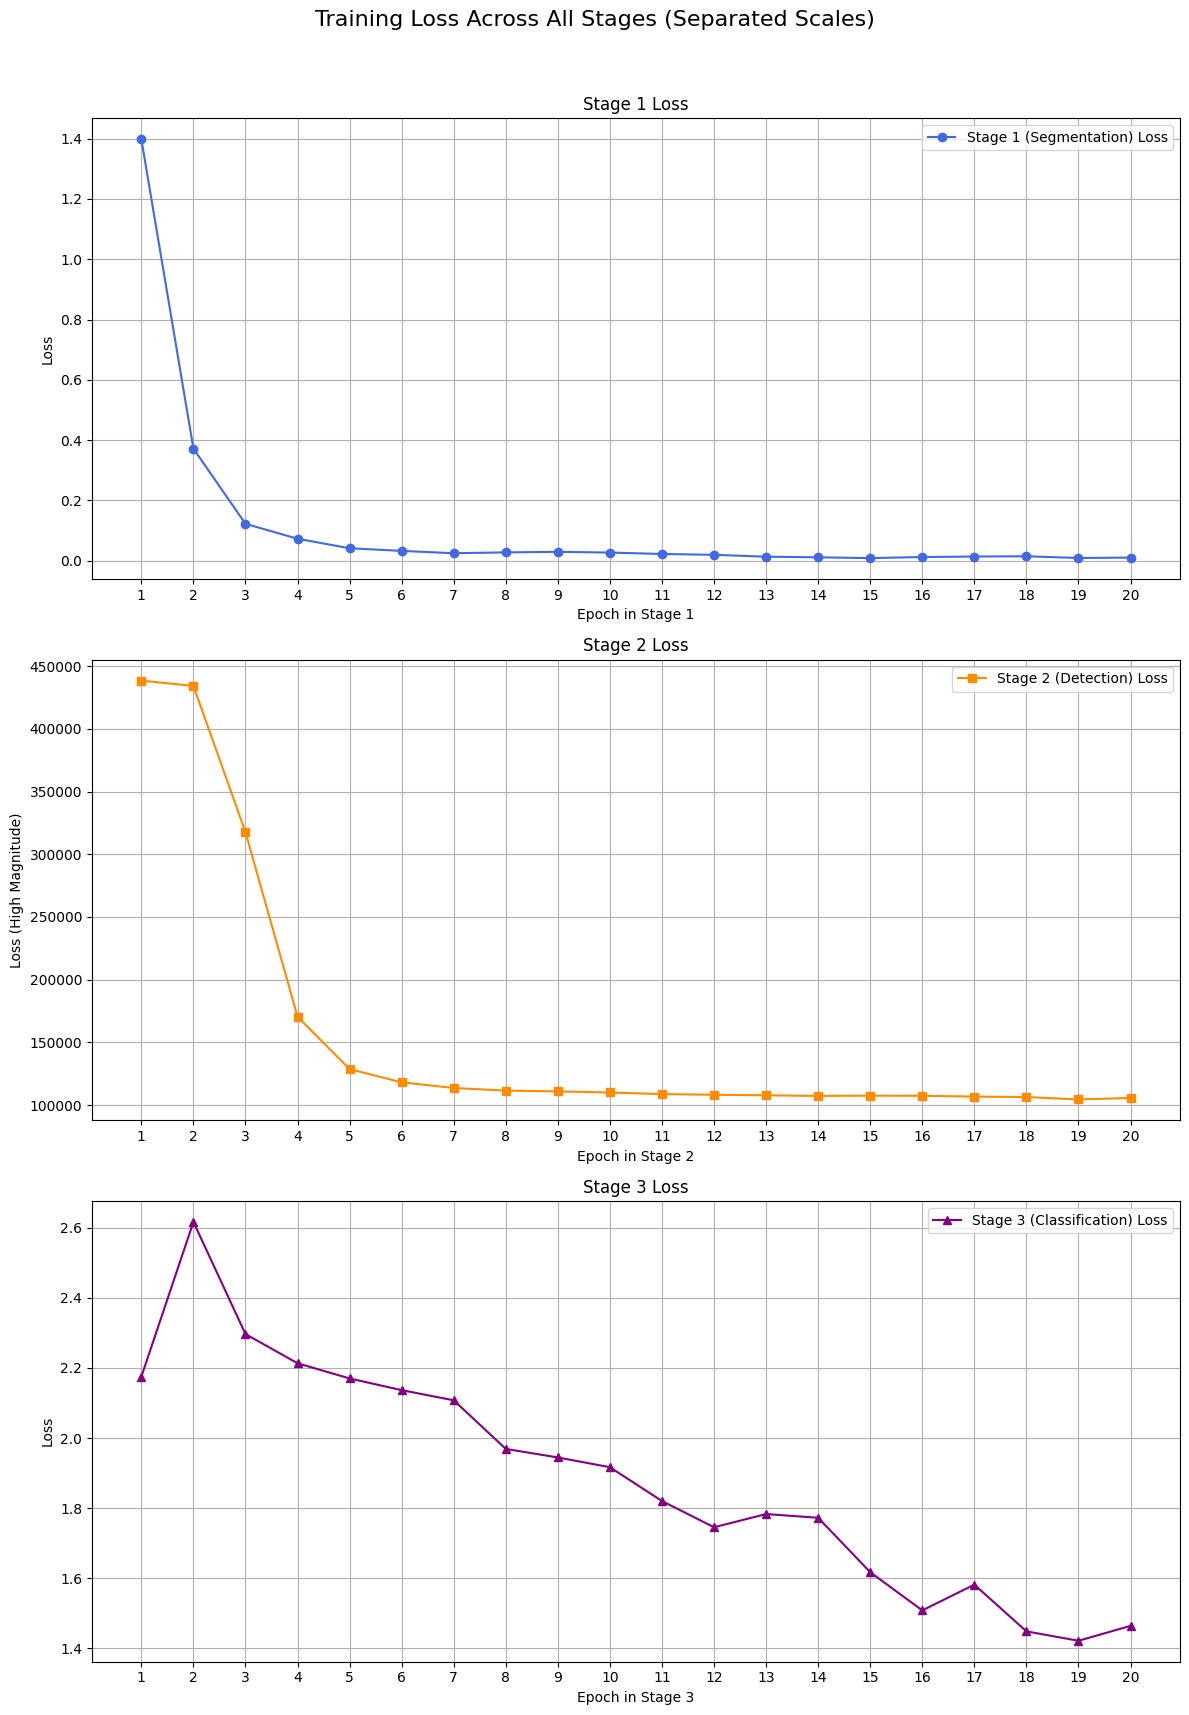

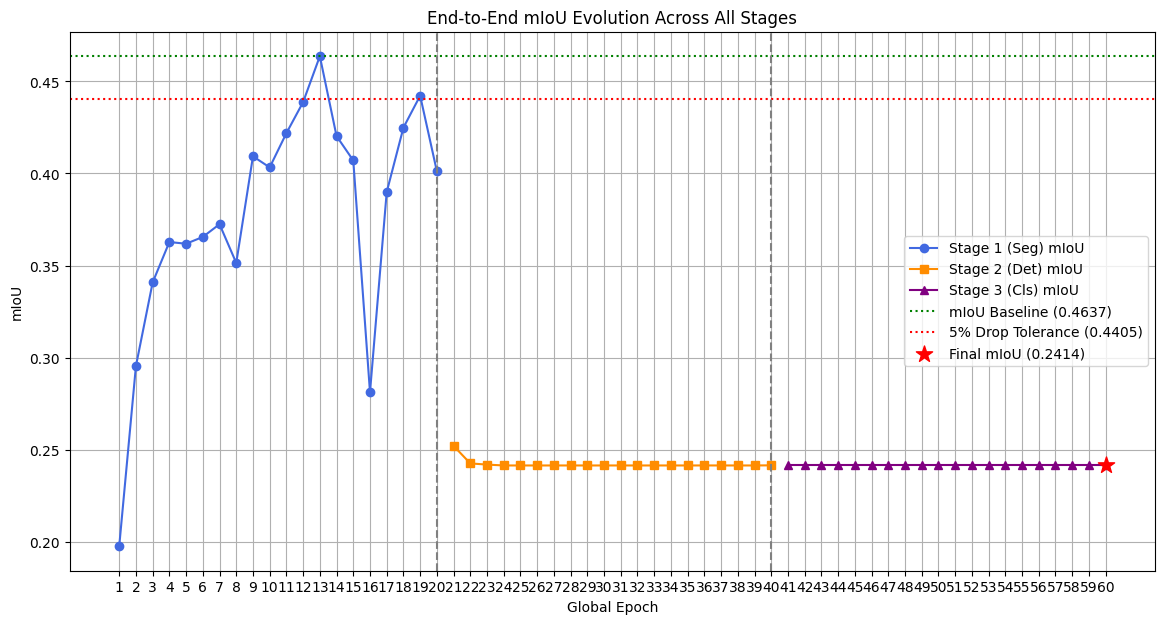

In [13]:
# ===============================================
# üìä Ë®ìÁ∑¥ÈÅéÁ®ãË¶ñË¶∫ÂåñÂàÜÊûê (ÂÑ™ÂåñÁâà)
# ===============================================
import matplotlib.pyplot as plt

# --- 1. Loss ËÆäÂåñÂàÜÊûêÂúñ (ÊãÜÂàÜÁÇ∫‰∏âÂÄãÂ≠êÂúñ) ---
# Âª∫Á´ã‰∏ÄÂÄãÂåÖÂê´ 3 ÂÄãÂ≠êÂúñÁöÑ FigureÔºåÊéíÂàóÁÇ∫ 3 Ë°å 1 Âàó
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Training Loss Across All Stages (Separated Scales)', fontsize=16)

# Â≠êÂúñ 1: Stage 1 (Segmentation)
axes[0].plot(range(1, stage1_len + 1), loss1_hist, 'o-', color='royalblue', label='Stage 1 (Segmentation) Loss')
axes[0].set_title('Stage 1 Loss')
axes[0].set_xlabel('Epoch in Stage 1')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(ticks=range(1, stage1_len + 1))

# Â≠êÂúñ 2: Stage 2 (Detection)
axes[1].plot(range(1, stage2_len + 1), loss2_hist, 's-', color='darkorange', label='Stage 2 (Detection) Loss')
axes[1].set_title('Stage 2 Loss')
axes[1].set_xlabel('Epoch in Stage 2')
axes[1].set_ylabel('Loss (High Magnitude)')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(ticks=range(1, stage2_len + 1))


# Â≠êÂúñ 3: Stage 3 (Classification)
axes[2].plot(range(1, stage3_len + 1), loss3_hist, '^-', color='purple', label='Stage 3 (Classification) Loss')
axes[2].set_title('Stage 3 Loss')
axes[2].set_xlabel('Epoch in Stage 3')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(ticks=range(1, stage3_len + 1))

# Ëá™ÂãïË™øÊï¥Â≠êÂúñÈñìË∑ùÔºåÈÅøÂÖçÊ®ôÁ±§ÈáçÁñä
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


# --- 2. mIoU ÂÆåÊï¥ÊºîÂåñË∂®Âã¢Âúñ (‰øùÊåÅ‰∏çËÆä) ---
plt.figure(figsize=(14, 7))

# Áπ™Ë£Ω‰∏âÂÄãÈöéÊÆµÁöÑ mIoU ÊºîÂåñÊõ≤Á∑ö
plt.plot(range(1, stage1_len + 1), miou1_hist, 'o-', color='royalblue', label='Stage 1 (Seg) mIoU')
plt.plot(range(stage1_len + 1, stage1_len + stage2_len + 1), miou2_hist, 's-', color='darkorange', label='Stage 2 (Det) mIoU')
plt.plot(range(stage1_len + stage2_len + 1, stage1_len + stage2_len + stage3_len + 1), miou3_hist, '^-', color='purple', label='Stage 3 (Cls) mIoU')

# Ê®ôÁ§∫Âü∫Ê∫ñÁ∑öÂíå 5% ‰∏ãÈôçÁöÑÂÆπÂøçÁ∑ö
mIoU_final = miou3_hist[-1] if miou3_hist else (miou2_hist[-1] if miou2_hist else miou1_hist[-1])
plt.axhline(y=mIoU_base, color='green', linestyle=':', label=f'mIoU Baseline ({mIoU_base:.4f})')
plt.axhline(y=mIoU_base * 0.95, color='red', linestyle=':', label=f'5% Drop Tolerance ({mIoU_base*0.95:.4f})')

# Áπ™Ë£ΩÈöéÊÆµÂàÜÈöîÁ∑ö
plt.axvline(x=stage1_len, color='grey', linestyle='--')
plt.axvline(x=stage1_len + stage2_len, color='grey', linestyle='--')

# Ê®ôÁ§∫ÊúÄÁµÇÁµêÊûú
plt.scatter(len(all_mious), mIoU_final, s=150, c='red', marker='*', zorder=5, label=f'Final mIoU ({mIoU_final:.4f})')

plt.title('End-to-End mIoU Evolution Across All Stages')
plt.xlabel('Global Epoch')
plt.ylabel('mIoU')
plt.xticks(ticks=range(1, len(all_mious) + 1))
plt.legend()
plt.grid(True)
plt.show()

## ÁÅΩÈõ£ÊÄßÈÅ∫ÂøòËôïÁêÜ( Replay buffer (‚â§ 10 images per task per step) )

In [14]:
### =================================================================
### ÂçÄÂ°ä‰∏ÄÔºöÊ®°Âûã„ÄÅË≥áÊñôÈõÜËàáËºîÂä©Â∑•ÂÖ∑ (ÂÆåÊï¥Áâà)
### =================================================================
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import average_precision_score

# ----------- 1. Áµ±‰∏ÄÊ®°ÂûãÂÆöÁæ© -----------
class UnifiedModel(nn.Module):
    def __init__(self, num_classes_cls=10, num_classes_det=10, num_classes_seg=21):
        super(UnifiedModel, self).__init__()
        # üîó Backbone: MobileNetV3 Small
        backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.backbone = backbone.features

        # üîó FPN Neck
        # ‚úÖ ‰øÆÊ≠£Ôºö‰ΩøÁî® MobileNetV3-Small features[3, 6, 12] Â±§ÁöÑÊ≠£Á¢∫Ëº∏Âá∫ÈÄöÈÅì [24, 40, 576]
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[24, 40, 576],
            out_channels=128,
            extra_blocks=LastLevelMaxPool()
        )

        # üß† Shared conv head
        self.shared_head = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # üéØ Output heads
        self.classifier = nn.Linear(128, num_classes_cls)
        self.det_head = nn.Conv2d(128, 5, 1)
        self.seg_head = nn.Conv2d(128, num_classes_seg, 1)

    def forward(self, x):
        feats = {}
        for i, layer in enumerate(self.backbone):
            x = layer(x)
            if i in [3, 6, 12]:
                 feats[f'feat{i}'] = x

        fpn_feats = self.fpn(feats)
        fpn_out = fpn_feats['feat3']

        shared = self.shared_head(fpn_out)
        B, C, H, W = shared.shape

        cls_logits = self.classifier(torch.mean(shared.view(B, C, -1), dim=2))

        det_raw = self.det_head(shared)
        # ‚úÖ ‰øÆÊ≠£ÔºöÂ∞á det_output ÁöÑÂΩ¢ÁãÄÂæû (B, H, W, 5) Êï¥ÂΩ¢ÁÇ∫ (B, H*W, 5)
        # ÈÄôÊ®£Êõ¥ÂÆπÊòìÁ¥¢ÂºïÂíåÊØîËºÉ
        det_output = det_raw.permute(0, 2, 3, 1).contiguous().view(B, -1, 5)

        seg_mask = self.seg_head(shared)

        return cls_logits, det_output, seg_mask

# ----------- 2. Ë≥áÊñôÈõÜÂÆöÁæ© -----------
class VOCSegmentationDataset(Dataset):
    """PASCAL VOC 2012 ÂàÜÂâ≤Ë≥áÊñôÈõÜ"""
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_paths = sorted([Path(image_dir) / f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.mask_paths = [p.with_suffix('.png') for p in self.image_paths]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
        mask = mask.squeeze(0).long()
        mask = mask.clone()
        mask[(mask > 20) & (mask != 255)] = 255
        return img, mask

class MiniCocoDetection(Dataset):
    """Mini COCO Áâ©‰ª∂ÂÅµÊ∏¨Ë≥áÊñôÈõÜ"""
    def __init__(self, img_dir, ann_path, transform=None):
        self.img_dir = Path(img_dir)
        self.transform = transform
        with open(ann_path) as f:
            coco_data = json.load(f)
        self.img_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
        self.annotations = {img['id']: [] for img in coco_data['images']}
        for ann in coco_data['annotations']:
            self.annotations[ann['image_id']].append(ann)
        self.ids = list(self.img_id_to_filename.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        file_name = self.img_id_to_filename[img_id]
        img_path = self.img_dir / file_name
        img = Image.open(img_path).convert("RGB")
        targets = []
        if img_id in self.annotations:
            for ann in self.annotations[img_id]:
                x, y, w, h = ann['bbox']
                targets.append([(x + w / 2), (y + h / 2), w, h, 1.0])
        targets = torch.tensor(targets, dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        return img, targets

def build_cls_dataset(root_dir, input_size=512):
    """Âª∫Á´ãÂàÜÈ°û‰ªªÂãôÁöÑË®ìÁ∑¥ËàáÈ©óË≠âË≥áÊñôÈõÜ"""
    transform = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor()])
    train_set = ImageFolder(root=Path(root_dir) / "train", transform=transform)
    val_set = ImageFolder(root=Path(root_dir) / "val", transform=transform)
    return train_set, val_set

def detection_collate_fn(batch):
    """ËôïÁêÜÁâ©‰ª∂ÂÅµÊ∏¨‰∏≠‰∏çÂêåÊï∏ÈáèÁöÑÊ®ôË®ª"""
    images = torch.stack([item[0] for item in batch], 0)
    targets = [item[1] for item in batch]
    return images, targets

# ----------- 3. Ë©ï‰º∞ËàáËºîÂä©ÂáΩÂºè -----------
def compute_mIoU(preds, targets, num_classes=21):
    """Ë®àÁÆó mIoU"""
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            ious.append(1.0)
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0

def evaluate_segmentation(model, val_loader, device="cuda"):
    """Ë©ï‰º∞ÂàÜÂâ≤‰ªªÂãôÁöÑ mIoU"""
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg_out = model(imgs)
            target_size = masks.shape[-2:]
            seg_out_upsampled = F.interpolate(seg_out, size=target_size, mode='bilinear', align_corners=False)
            preds = torch.argmax(seg_out_upsampled, dim=1)
            all_preds.append(preds)
            all_targets.append(masks)
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    mIoU = compute_mIoU(all_preds, all_targets)
    return mIoU

def evaluate_classification(model, val_loader, device="cuda"):
    """Ë©ï‰º∞ÂàÜÈ°û‰ªªÂãôÁöÑ mAP Âíå Top-1 Accuracy (‰øÆÊ≠£Áâà)"""
    model.eval()
    all_logits, all_labels = [], []
    num_classes = model.classifier.out_features

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            # Âõ†ÁÇ∫ labels ‰∏çÈúÄË¶ÅÂèÉËàáÊ®°ÂûãÈÅãÁÆóÔºåÊâÄ‰ª•ÂèØ‰ª•Áõ¥Êé•ÁßªËá≥ CPU
            labels = labels.cpu()

            logits, _, _ = model(imgs)

            all_logits.append(logits.cpu())
            all_labels.append(labels) # ‚úÖ ‰øÆÊ≠£ÔºöÁèæÂú®Êî∂ÈõÜÁöÑ labels ‰øùË≠âÂú® CPU ‰∏ä

    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    probs = F.softmax(logits, dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    top1 = (preds == labels.numpy()).mean()

    try:
        y_true_one_hot = np.eye(num_classes)[labels.numpy()]
        mAP = average_precision_score(y_true_one_hot, probs, average='macro')
    except Exception as e:
        print(f"Could not compute mAP: {e}")
        mAP = 0.0

    return mAP, top1

def print_grad_status(model):
    """Âç∞Âá∫Ê®°Âûã‰∏ªË¶ÅÈÉ®ÂàÜÁöÑÊ¢ØÂ∫¶ÁãÄÊÖã"""
    print("--- Ê®°ÂûãÊ¢ØÂ∫¶ÁãÄÊÖãÊ™¢Êü• ---")
    for name, param in model.named_parameters():
        if '.' in name:
            module_name = name.split('.')[0]
            if module_name in ['backbone', 'fpn', 'shared_head', 'classifier', 'det_head', 'seg_head']:
                 print(f"{module_name.ljust(15)} requires_grad: {param.requires_grad}")
                 break # Âè™Âç∞Âá∫ÊØèÂÄãÊ®°ÁµÑÁöÑÁ¨¨‰∏ÄÂÄãÂèÉÊï∏ÁãÄÊÖãÂç≥ÂèØ
    print("--------------------------")

In [15]:
### =================================================================
### ÂçÄÂ°ä‰∫åÔºöÂÖ∑ÂÇô„ÄåÁ∂ìÈ©óÂõûÊîæ„ÄçÁöÑË®ìÁ∑¥ÂºïÊìé (ÂÆåÊï¥Áâà)
### =================================================================

def train_stage1_segmentation(model, train_loader, val_loader, epochs, lr, device):
    """Stage 1: Segmentation Ë®ìÁ∑¥ÂºïÊìé (‰øÆÊ≠£Áâà)"""
    print(f"üéØ Stage 1: Segmentation Ë®ìÁ∑¥‰∏≠ÔºåÂÖ± {epochs} ÂÄã Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

    loss_history, miou_history = [], []
    best_mIoU = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, masks in progress_bar:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg_out = model(imgs)

            # ‚úÖ ‰øÆÊ≠£ÔºöÂú®Ë®àÁÆó Loss ÂâçÔºåÂ∞áÈ´òËß£ÊûêÂ∫¶ÁöÑ mask ÈôçÊé°Ê®£‰ª•ÂåπÈÖç seg_out ÁöÑÂ§ßÂ∞è
            target_size = seg_out.shape[-2:] # Áç≤ÂèñÊ®°ÂûãËº∏Âá∫ÁöÑ H, WÔºå‰æãÂ¶Ç (64, 64)

            # interpolate ÈúÄË¶Å 4D Ëº∏ÂÖ• (N, C, H, W)ÔºåÊâÄ‰ª•ÂÖà unsqueeze(1) Â¢ûÂä†ÈÄöÈÅìÁ∂≠Â∫¶
            # ‰∏¶ËΩâÁÇ∫ floatÔºåÈôçÊé°Ê®£ÂæåÂÜç squeeze(1) ÁßªÈô§ÈÄöÈÅìÁ∂≠Â∫¶‰∏¶ËΩâÂõû long
            masks_downsampled = F.interpolate(
                masks.unsqueeze(1).float(),
                size=target_size,
                mode='nearest'
            ).squeeze(1).long()

            # ‰ΩøÁî®ÈôçÊé°Ê®£ÂæåÁöÑ mask Ë®àÁÆó Loss
            loss = criterion(seg_out, masks_downsampled)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"üîß Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        epoch_mIoU = evaluate_segmentation(model, val_loader, device)
        miou_history.append(epoch_mIoU)
        best_mIoU = max(best_mIoU, epoch_mIoU)
        print(f"üìä mIoU: {epoch_mIoU:.4f}")

    print(f"\n‚úÖ Stage 1 ÂÆåÊàêÔºÅË®òÈåÑ mIoU_base = {best_mIoU:.4f}")
    return best_mIoU, loss_history, miou_history

def train_stage2_detection_with_replay(model, det_loader, seg_replay_loader, seg_val_loader, mIoU_base, epochs, lr, replay_weight, device):
    """Stage 2: Detection Ë®ìÁ∑¥ÂºïÊìé (Âê´ Segmentation ÂõûÊîæ) (‰øÆÊ≠£Áâà)"""
    print(f"üîé Stage 2: Detection Ë®ìÁ∑¥‰∏≠ (ÂïüÁî® Replay)ÔºåÂÖ± {epochs} ÂÄã Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    det_loss_fn = torch.nn.MSELoss()
    seg_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    loss_history, miou_history = [], []
    det_iter, replay_iter = iter(det_loader), iter(seg_replay_loader)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(range(len(det_loader)), desc=f"Epoch {epoch+1}/{epochs}")
        for step in progress_bar:
            try:
                imgs_det, targets_det = next(det_iter)
            except StopIteration:
                det_iter = iter(det_loader); imgs_det, targets_det = next(det_iter)
            try:
                imgs_seg, masks_seg = next(replay_iter)
            except StopIteration:
                replay_iter = iter(seg_replay_loader); imgs_seg, masks_seg = next(replay_iter)

            main_bs = imgs_det.shape[0]
            all_imgs = torch.cat([imgs_det, imgs_seg], dim=0).to(device)
            targets_det = [t.to(device) for t in targets_det]
            masks_seg = masks_seg.to(device)
            optimizer.zero_grad()
            _, det_out, seg_out = model(all_imgs)

            loss_det, total_loss = 0, 0
            det_preds = det_out[:main_bs]
            for i in range(main_bs):
                if targets_det[i].shape[0] > 0:
                    loss_det += det_loss_fn(det_preds[i, :targets_det[i].shape[0], :], targets_det[i])

            # ‚úÖ ‰øÆÊ≠£ÔºöÂú®Ë®àÁÆó Replay Loss ÂâçÔºåÂ∞áÈ´òËß£ÊûêÂ∫¶ÁöÑ mask ÈôçÊé°Ê®£
            seg_preds = seg_out[main_bs:]
            target_size = seg_preds.shape[-2:]
            masks_seg_downsampled = F.interpolate(masks_seg.unsqueeze(1).float(), size=target_size, mode='nearest').squeeze(1).long()
            loss_seg_replay = seg_loss_fn(seg_preds, masks_seg_downsampled)

            if isinstance(loss_det, torch.Tensor): total_loss += loss_det
            total_loss += replay_weight * loss_seg_replay

            if isinstance(total_loss, torch.Tensor):
                total_loss.backward(); optimizer.step()
                running_loss += total_loss.item()

        epoch_loss = running_loss / len(det_loader) if len(det_loader) > 0 else 0
        loss_history.append(epoch_loss)
        print(f"üîß Epoch {epoch+1} Loss: {epoch_loss:.4f}")
        epoch_mIoU = evaluate_segmentation(model, seg_val_loader, device)
        miou_history.append(epoch_mIoU)
        print(f"üìä mIoU: {epoch_mIoU:.4f}")

    final_mIoU = miou_history[-1] if miou_history else mIoU_base
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    print(f"üìâ Stage 2 ÊúÄÁµÇ mIoU drop: {mIoU_drop:.4f}")
    return mIoU_drop, loss_history, miou_history
def train_stage3_classification_with_replay(model, cls_loader, seg_replay_loader, cls_val_loader, seg_val_loader, mIoU_base, epochs, lr, replay_weight, device):
    """Stage 3: Classification Ë®ìÁ∑¥ÂºïÊìé (Âê´ Segmentation ÂõûÊîæ) (‰øÆÊ≠£Áâà)"""
    print(f"üìò Stage 3: Classification Ë®ìÁ∑¥‰∏≠ (ÂïüÁî® Replay)ÔºåÂÖ± {epochs} ÂÄã Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cls_loss_fn = torch.nn.CrossEntropyLoss()
    seg_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    loss_history, miou_history = [], []
    cls_iter, replay_iter = iter(cls_loader), iter(seg_replay_loader)

    mAP_base, Top1_base = evaluate_classification(model, cls_val_loader, device)
    print(f"Initial Classification Performance: mAP={mAP_base:.4f}, Top-1={Top1_base:.4f}")

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(range(len(cls_loader)), desc=f"Epoch {epoch+1}/{epochs}")
        for step in progress_bar:
            try:
                imgs_cls, labels_cls = next(cls_iter)
            except StopIteration:
                cls_iter = iter(cls_loader); imgs_cls, labels_cls = next(cls_iter)
            try:
                imgs_seg, masks_seg = next(replay_iter)
            except StopIteration:
                replay_iter = iter(seg_replay_loader); imgs_seg, masks_seg = next(replay_iter)

            main_bs = imgs_cls.shape[0]
            all_imgs = torch.cat([imgs_cls, imgs_seg], dim=0).to(device)
            labels_cls, masks_seg = labels_cls.to(device), masks_seg.to(device)
            optimizer.zero_grad()
            cls_logits, _, seg_out = model(all_imgs)

            loss_cls = cls_loss_fn(cls_logits[:main_bs], labels_cls)

            # ‚úÖ ‰øÆÊ≠£ÔºöÂú®Ë®àÁÆó Replay Loss ÂâçÔºåÂ∞áÈ´òËß£ÊûêÂ∫¶ÁöÑ mask ÈôçÊé°Ê®£
            seg_preds = seg_out[main_bs:]
            target_size = seg_preds.shape[-2:]
            masks_seg_downsampled = F.interpolate(masks_seg.unsqueeze(1).float(), size=target_size, mode='nearest').squeeze(1).long()
            loss_seg_replay = seg_loss_fn(seg_preds, masks_seg_downsampled)

            total_loss = loss_cls + replay_weight * loss_seg_replay

            total_loss.backward(); optimizer.step()
            running_loss += total_loss.item()

        # ... (ÂæåÁ∫åÁöÑ loss Âíå mIoU Ë®òÈåÑ„ÄÅË©ï‰º∞ÈÉ®ÂàÜ‰∏çËÆä) ...

        epoch_loss = running_loss / len(cls_loader)
        loss_history.append(epoch_loss)
        print(f"üîß Epoch {epoch+1} Loss: {epoch_loss:.4f}")
        epoch_mIoU = evaluate_segmentation(model, seg_val_loader, device)
        miou_history.append(epoch_mIoU)
        print(f"üìä mIoU: {epoch_mIoU:.4f}")

    final_mIoU = miou_history[-1] if miou_history else mIoU_base
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    mAP_now, top1_now = evaluate_classification(model, cls_val_loader, device)
    mAP_drop = max(0, mAP_base - mAP_now)
    top1_drop = max(0, Top1_base - top1_now)

    print(f"üìâ mIoU_drop: {mIoU_drop:.4f}, mAP_drop: {mAP_drop:.4f}, Top1_drop: {top1_drop:.4f}")
    return mIoU_drop, mAP_drop, top1_drop, loss_history, miou_history

In [16]:
### =================================================================
### ÂçÄÂ°ä‰∏âÔºö‰ΩøÁî®„ÄåÁ∂ìÈ©óÂõûÊîæ„ÄçÁöÑ‰∏ªÂü∑Ë°åÊµÅÁ®ã
### =================================================================

# 1. CONFIGURATION BLOCK
CONFIG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "input_size": 512,
    "main_batch_size": 6,          # ‰∏ªË¶Å‰ªªÂãôÁöÑ batch size
    "replay_batch_size": 4,        # ÂõûÊîæ‰ªªÂãôÁöÑ batch size (6+4=10 <= 10)
    "replay_loss_weight": 0.8,     # ÂõûÊîæ loss ÁöÑÊ¨äÈáçÔºåÂèØË™øÊï¥
    "epochs": {"stage1": 20, "stage2": 20, "stage3": 20},
    "learning_rates": {"stage1": 1e-3, "stage2": 1e-4, "stage3": 1e-4},
    "data_paths": {
        "seg_train": "data/mini_voc_seg/train",
        "seg_val": "data/mini_voc_seg/val",
        "det_train": "data/mini_coco_det/train",
        "det_ann_train": "data/mini_coco_det/annotations/mini_instances_train2017.json",
        "cls_root": "data/imagenette_160",
    }
}

# 2. DATA PREPARATION
def prepare_dataloaders_for_replay(config):
    """Âª∫Á´ãÊâÄÊúâ‰ªªÂãôÊâÄÈúÄÔºåÂåÖÂê´ÂõûÊîæÁöÑ DataLoaders"""
    print("--- Ê≠£Âú®Ê∫ñÂÇôÊâÄÊúâ DataLoaders (Âê´ Replay)... ---")
    img_tf = transforms.Compose([transforms.Resize((config["input_size"], config["input_size"])), transforms.ToTensor()])
    mask_tf = transforms.Compose([transforms.Resize((config["input_size"], config["input_size"]), interpolation=Image.NEAREST), transforms.PILToTensor()])

    seg_train_ds = VOCSegmentationDataset(config["data_paths"]["seg_train"], img_tf, mask_tf)
    seg_val_ds = VOCSegmentationDataset(config["data_paths"]["seg_val"], img_tf, mask_tf)
    det_train_ds = MiniCocoDetection(config["data_paths"]["det_train"], config["data_paths"]["det_ann_train"], img_tf)
    cls_train_ds, cls_val_ds = build_cls_dataset(config["data_paths"]["cls_root"])

    loaders = {
        "seg_train": DataLoader(seg_train_ds, batch_size=config["main_batch_size"], shuffle=True),
        "seg_val": DataLoader(seg_val_ds, batch_size=1),
        "seg_replay": DataLoader(seg_train_ds, batch_size=config["replay_batch_size"], shuffle=True, drop_last=True),
        "det_train": DataLoader(det_train_ds, batch_size=config["main_batch_size"], shuffle=True, collate_fn=detection_collate_fn),
        "cls_train": DataLoader(cls_train_ds, batch_size=config["main_batch_size"], shuffle=True),
        "cls_val": DataLoader(cls_val_ds, batch_size=config["main_batch_size"])
    }
    print("‚úÖ ÊâÄÊúâ DataLoaders Ê∫ñÂÇôÂÆåÊàêÔºÅ")
    return loaders

# 3. MAIN EXECUTION
model = UnifiedModel().to(CONFIG["device"])
dataloaders = prepare_dataloaders_for_replay(CONFIG)

# Stage 1
mIoU_base, loss1_hist, miou1_hist = train_stage1_segmentation(
    model, dataloaders["seg_train"], dataloaders["seg_val"],
    epochs=CONFIG["epochs"]["stage1"], lr=CONFIG["learning_rates"]["stage1"], device=CONFIG["device"]
)

# Stage 2
print_grad_status(model)
mIoU_drop2, loss2_hist, miou2_hist = train_stage2_detection_with_replay(
    model, dataloaders["det_train"], dataloaders["seg_replay"], dataloaders["seg_val"],
    mIoU_base=mIoU_base, epochs=CONFIG["epochs"]["stage2"],
    lr=CONFIG["learning_rates"]["stage2"], replay_weight=CONFIG["replay_loss_weight"], device=CONFIG["device"]
)

# Stage 3
print_grad_status(model)
mIoU_drop3, mAP_drop3, Top1_drop3, loss3_hist, miou3_hist = train_stage3_classification_with_replay(
    model, dataloaders["cls_train"], dataloaders["seg_replay"], dataloaders["cls_val"], dataloaders["seg_val"],
    mIoU_base=mIoU_base, epochs=CONFIG["epochs"]["stage3"],
    lr=CONFIG["learning_rates"]["stage3"], replay_weight=CONFIG["replay_loss_weight"], device=CONFIG["device"]
)

# --- ÂΩôÁ∏ΩÊï∏Êìö‰ª•‰æõÁπ™Âúñ ---
all_losses = loss1_hist + loss2_hist + loss3_hist
all_mious = miou1_hist + miou2_hist + miou3_hist
stage1_len, stage2_len, stage3_len = len(loss1_hist), len(loss2_hist), len(loss3_hist)

print("\n--- Ë®ìÁ∑¥ÊµÅÁ®ãÂ∑≤ÂÖ®ÈÉ®ÂÆåÊàêÔºåÂèØ‰ª•Âü∑Ë°åË¶ñË¶∫ÂåñÂàÜÊûê Cell„ÄÇ---")

--- Ê≠£Âú®Ê∫ñÂÇôÊâÄÊúâ DataLoaders (Âê´ Replay)... ---
‚úÖ ÊâÄÊúâ DataLoaders Ê∫ñÂÇôÂÆåÊàêÔºÅ
üéØ Stage 1: Segmentation Ë®ìÁ∑¥‰∏≠ÔºåÂÖ± 20 ÂÄã Epochs


Epoch 1/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:05<00:00,  7.29it/s]


üîß Epoch 1 Loss: 1.3278
üìä mIoU: 0.8448


Epoch 2/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:04<00:00,  8.40it/s]


üîß Epoch 2 Loss: 0.3735
üìä mIoU: 0.8979


Epoch 3/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:05<00:00,  7.32it/s]


üîß Epoch 3 Loss: 0.1057
üìä mIoU: 0.8984


Epoch 4/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:05<00:00,  7.61it/s]


üîß Epoch 4 Loss: 0.0760
üìä mIoU: 0.8988


Epoch 5/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:04<00:00,  8.30it/s]


üîß Epoch 5 Loss: 0.0633
üìä mIoU: 0.9044


Epoch 6/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:05<00:00,  7.46it/s]


üîß Epoch 6 Loss: 0.0454
üìä mIoU: 0.9067


Epoch 7/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:04<00:00,  8.38it/s]


üîß Epoch 7 Loss: 0.0318
üìä mIoU: 0.9084


Epoch 8/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:04<00:00,  8.23it/s]


üîß Epoch 8 Loss: 0.0423
üìä mIoU: 0.9080


Epoch 9/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:05<00:00,  7.50it/s]


üîß Epoch 9 Loss: 0.0251
üìä mIoU: 0.9123


Epoch 10/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:04<00:00,  8.41it/s]


üîß Epoch 10 Loss: 0.0249
üìä mIoU: 0.9178


Epoch 11/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:05<00:00,  7.28it/s]


üîß Epoch 11 Loss: 0.0185
üìä mIoU: 0.9053


Epoch 12/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:04<00:00,  8.42it/s]


üîß Epoch 12 Loss: 0.0251
üìä mIoU: 0.9098


Epoch 13/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:04<00:00,  8.29it/s]


üîß Epoch 13 Loss: 0.0231
üìä mIoU: 0.9059


Epoch 14/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:05<00:00,  7.32it/s]


üîß Epoch 14 Loss: 0.0285
üìä mIoU: 0.9064


Epoch 15/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:04<00:00,  8.32it/s]


üîß Epoch 15 Loss: 0.0329
üìä mIoU: 0.9016


Epoch 16/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:05<00:00,  7.77it/s]


üîß Epoch 16 Loss: 0.0374
üìä mIoU: 0.9136


Epoch 17/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:05<00:00,  7.79it/s]


üîß Epoch 17 Loss: 0.0189
üìä mIoU: 0.9056


Epoch 18/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:04<00:00,  8.45it/s]


üîß Epoch 18 Loss: 0.0159
üìä mIoU: 0.9078


Epoch 19/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:08<00:00,  4.91it/s]


üîß Epoch 19 Loss: 0.0257
üìä mIoU: 0.9070


Epoch 20/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  6.66it/s]


üîß Epoch 20 Loss: 0.0424
üìä mIoU: 0.9068

‚úÖ Stage 1 ÂÆåÊàêÔºÅË®òÈåÑ mIoU_base = 0.9178
--- Ê®°ÂûãÊ¢ØÂ∫¶ÁãÄÊÖãÊ™¢Êü• ---
backbone        requires_grad: True
--------------------------
üîé Stage 2: Detection Ë®ìÁ∑¥‰∏≠ (ÂïüÁî® Replay)ÔºåÂÖ± 20 ÂÄã Epochs


Epoch 1/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:08<00:00,  4.84it/s]


üîß Epoch 1 Loss: 329066.5266
üìä mIoU: 0.9042


Epoch 2/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:08<00:00,  4.82it/s]


üîß Epoch 2 Loss: 325739.9113
üìä mIoU: 0.8978


Epoch 3/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:07<00:00,  5.24it/s]


üîß Epoch 3 Loss: 309704.3809
üìä mIoU: 0.8916


Epoch 4/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:07<00:00,  5.13it/s]


üîß Epoch 4 Loss: 248110.0184
üìä mIoU: 0.8916


Epoch 5/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:08<00:00,  4.97it/s]


üîß Epoch 5 Loss: 197287.6840
üìä mIoU: 0.8916


Epoch 6/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:08<00:00,  4.83it/s]


üîß Epoch 6 Loss: 167691.6475
üìä mIoU: 0.8916


Epoch 7/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:08<00:00,  4.70it/s]


üîß Epoch 7 Loss: 150316.3748
üìä mIoU: 0.8916


Epoch 8/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:08<00:00,  4.70it/s]


üîß Epoch 8 Loss: 139184.6570
üìä mIoU: 0.8916


Epoch 9/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:09<00:00,  4.40it/s]


üîß Epoch 9 Loss: 130341.5051
üìä mIoU: 0.8916


Epoch 10/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:08<00:00,  4.87it/s]


üîß Epoch 10 Loss: 123184.0445
üìä mIoU: 0.8916


Epoch 11/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:07<00:00,  5.11it/s]


üîß Epoch 11 Loss: 116122.1885
üìä mIoU: 0.8916


Epoch 12/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:07<00:00,  5.25it/s]


üîß Epoch 12 Loss: 111398.1667
üìä mIoU: 0.8916


Epoch 13/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:08<00:00,  4.68it/s]


üîß Epoch 13 Loss: 106809.9090
üìä mIoU: 0.8916


Epoch 14/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:07<00:00,  5.14it/s]


üîß Epoch 14 Loss: 102812.0828
üìä mIoU: 0.8916


Epoch 15/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:08<00:00,  4.90it/s]


üîß Epoch 15 Loss: 99258.1723
üìä mIoU: 0.8916


Epoch 16/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:07<00:00,  5.03it/s]


üîß Epoch 16 Loss: 96530.8371
üìä mIoU: 0.8916


Epoch 17/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:08<00:00,  4.95it/s]


üîß Epoch 17 Loss: 94588.4944
üìä mIoU: 0.8916


Epoch 18/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:07<00:00,  5.13it/s]


üîß Epoch 18 Loss: 92268.7827
üìä mIoU: 0.8916


Epoch 19/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:07<00:00,  5.11it/s]


üîß Epoch 19 Loss: 89833.7269
üìä mIoU: 0.8916


Epoch 20/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:07<00:00,  5.37it/s]


üîß Epoch 20 Loss: 87790.3023
üìä mIoU: 0.8916
üìâ Stage 2 ÊúÄÁµÇ mIoU drop: 0.0262
--- Ê®°ÂûãÊ¢ØÂ∫¶ÁãÄÊÖãÊ™¢Êü• ---
backbone        requires_grad: True
--------------------------
üìò Stage 3: Classification Ë®ìÁ∑¥‰∏≠ (ÂïüÁî® Replay)ÔºåÂÖ± 20 ÂÄã Epochs
Initial Classification Performance: mAP=0.2135, Top-1=0.0833


Epoch 1/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.98it/s]


üîß Epoch 1 Loss: 2.3773
üìä mIoU: 0.8924


Epoch 2/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.85it/s]


üîß Epoch 2 Loss: 2.2843
üìä mIoU: 0.9020


Epoch 3/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  6.00it/s]


üîß Epoch 3 Loss: 2.1819
üìä mIoU: 0.9032


Epoch 4/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  6.32it/s]


üîß Epoch 4 Loss: 2.0711
üìä mIoU: 0.9038


Epoch 5/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  6.02it/s]


üîß Epoch 5 Loss: 1.9273
üìä mIoU: 0.9010


Epoch 6/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.90it/s]


üîß Epoch 6 Loss: 1.8007
üìä mIoU: 0.9030


Epoch 7/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.96it/s]


üîß Epoch 7 Loss: 1.6271
üìä mIoU: 0.9018


Epoch 8/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  6.21it/s]


üîß Epoch 8 Loss: 1.4767
üìä mIoU: 0.9012


Epoch 9/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.97it/s]


üîß Epoch 9 Loss: 1.3670
üìä mIoU: 0.9038


Epoch 10/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.88it/s]


üîß Epoch 10 Loss: 1.2430
üìä mIoU: 0.9016


Epoch 11/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.92it/s]


üîß Epoch 11 Loss: 1.1607
üìä mIoU: 0.9005


Epoch 12/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  6.28it/s]


üîß Epoch 12 Loss: 1.0514
üìä mIoU: 0.9032


Epoch 13/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.99it/s]


üîß Epoch 13 Loss: 1.0266
üìä mIoU: 0.9011


Epoch 14/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.76it/s]


üîß Epoch 14 Loss: 0.9239
üìä mIoU: 0.9010


Epoch 15/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.92it/s]


üîß Epoch 15 Loss: 0.8824
üìä mIoU: 0.9103


Epoch 16/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  6.25it/s]


üîß Epoch 16 Loss: 0.8348
üìä mIoU: 0.9116


Epoch 17/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  6.03it/s]


üîß Epoch 17 Loss: 0.7029
üìä mIoU: 0.9068


Epoch 18/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.83it/s]


üîß Epoch 18 Loss: 0.6869
üìä mIoU: 0.9125


Epoch 19/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  5.82it/s]


üîß Epoch 19 Loss: 0.6576
üìä mIoU: 0.9111


Epoch 20/20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40/40 [00:06<00:00,  6.24it/s]


üîß Epoch 20 Loss: 0.4892
üìä mIoU: 0.9135
üìâ mIoU_drop: 0.0044, mAP_drop: 0.0000, Top1_drop: 0.0000

--- Ë®ìÁ∑¥ÊµÅÁ®ãÂ∑≤ÂÖ®ÈÉ®ÂÆåÊàêÔºåÂèØ‰ª•Âü∑Ë°åË¶ñË¶∫ÂåñÂàÜÊûê Cell„ÄÇ---


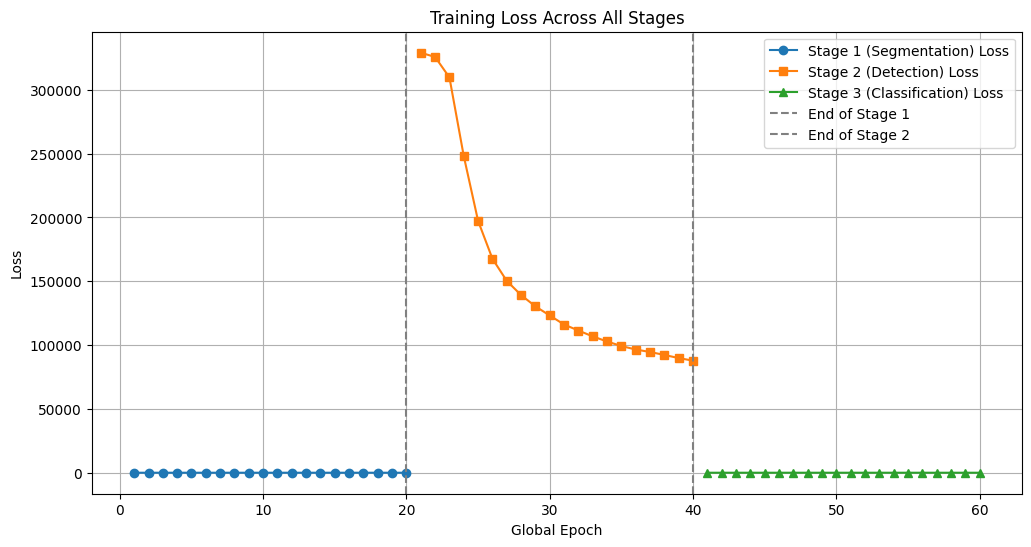

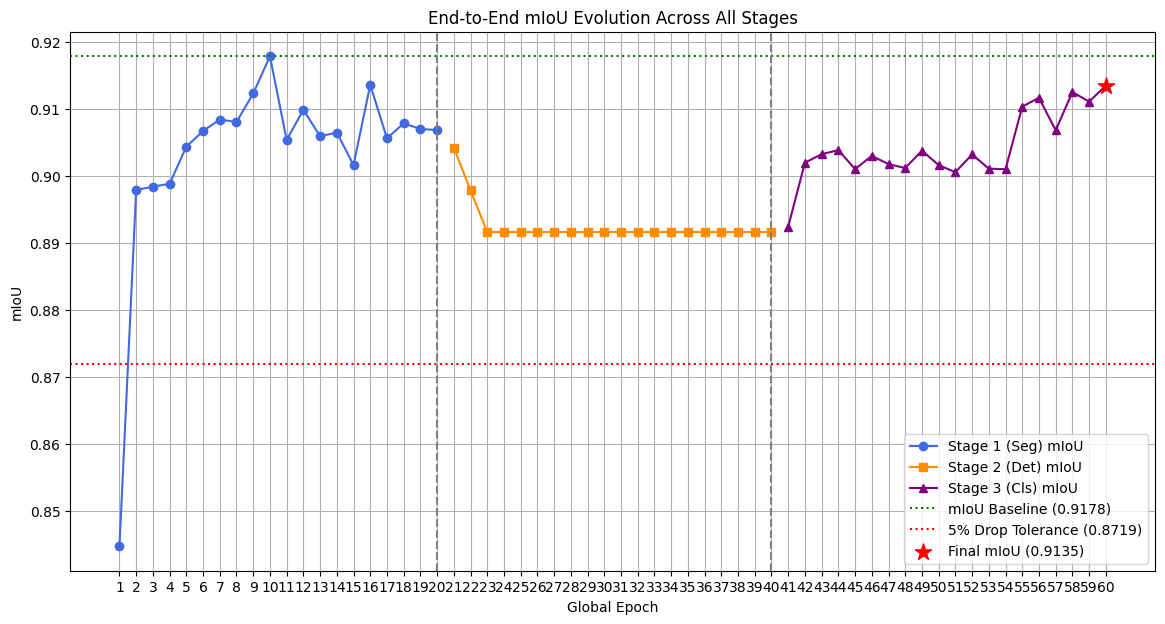

In [17]:
# ===============================================
# üìä Ë®ìÁ∑¥ÈÅéÁ®ãË¶ñË¶∫ÂåñÂàÜÊûê
# ===============================================
import matplotlib.pyplot as plt
# 1. Loss ËÆäÂåñÂàÜÊûêÂúñ
plt.figure(figsize=(12, 6))
plt.plot(range(1, stage1_len + 1), loss1_hist, 'o-', label='Stage 1 (Segmentation) Loss')
plt.plot(range(stage1_len + 1, stage1_len + stage2_len + 1), loss2_hist, 's-', label='Stage 2 (Detection) Loss')
plt.plot(range(stage1_len + stage2_len + 1, stage1_len + stage2_len + stage3_len + 1), loss3_hist, '^-', label='Stage 3 (Classification) Loss')

# Áπ™Ë£ΩÈöéÊÆµÂàÜÈöîÁ∑ö
plt.axvline(x=stage1_len, color='grey', linestyle='--', label='End of Stage 1')
plt.axvline(x=stage1_len + stage2_len, color='grey', linestyle='--', label='End of Stage 2')

plt.title('Training Loss Across All Stages')
plt.xlabel('Global Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2. mIoU ÂÆåÊï¥ÊºîÂåñË∂®Âã¢Âúñ
plt.figure(figsize=(14, 7))

# Áπ™Ë£Ω‰∏âÂÄãÈöéÊÆµÁöÑ mIoU ÊºîÂåñÊõ≤Á∑ö
plt.plot(range(1, stage1_len + 1), miou1_hist, 'o-', color='royalblue', label='Stage 1 (Seg) mIoU')
plt.plot(range(stage1_len + 1, stage1_len + stage2_len + 1), miou2_hist, 's-', color='darkorange', label='Stage 2 (Det) mIoU')
plt.plot(range(stage1_len + stage2_len + 1, stage1_len + stage2_len + stage3_len + 1), miou3_hist, '^-', color='purple', label='Stage 3 (Cls) mIoU')

# Ê®ôÁ§∫Âü∫Ê∫ñÁ∑öÂíå 5% ‰∏ãÈôçÁöÑÂÆπÂøçÁ∑ö
mIoU_final = miou3_hist[-1]
plt.axhline(y=mIoU_base, color='green', linestyle=':', label=f'mIoU Baseline ({mIoU_base:.4f})')
plt.axhline(y=mIoU_base * 0.95, color='red', linestyle=':', label=f'5% Drop Tolerance ({mIoU_base*0.95:.4f})')

# Áπ™Ë£ΩÈöéÊÆµÂàÜÈöîÁ∑ö
plt.axvline(x=stage1_len, color='grey', linestyle='--')
plt.axvline(x=stage1_len + stage2_len, color='grey', linestyle='--')

# Ê®ôÁ§∫ÊúÄÁµÇÁµêÊûú
plt.scatter(len(all_mious), mIoU_final, s=150, c='red', marker='*', zorder=5, label=f'Final mIoU ({mIoU_final:.4f})')

plt.title('End-to-End mIoU Evolution Across All Stages')
plt.xlabel('Global Epoch')
plt.ylabel('mIoU')
plt.xticks(ticks=range(1, len(all_mious) + 1))
plt.legend()
plt.grid(True)
plt.show()

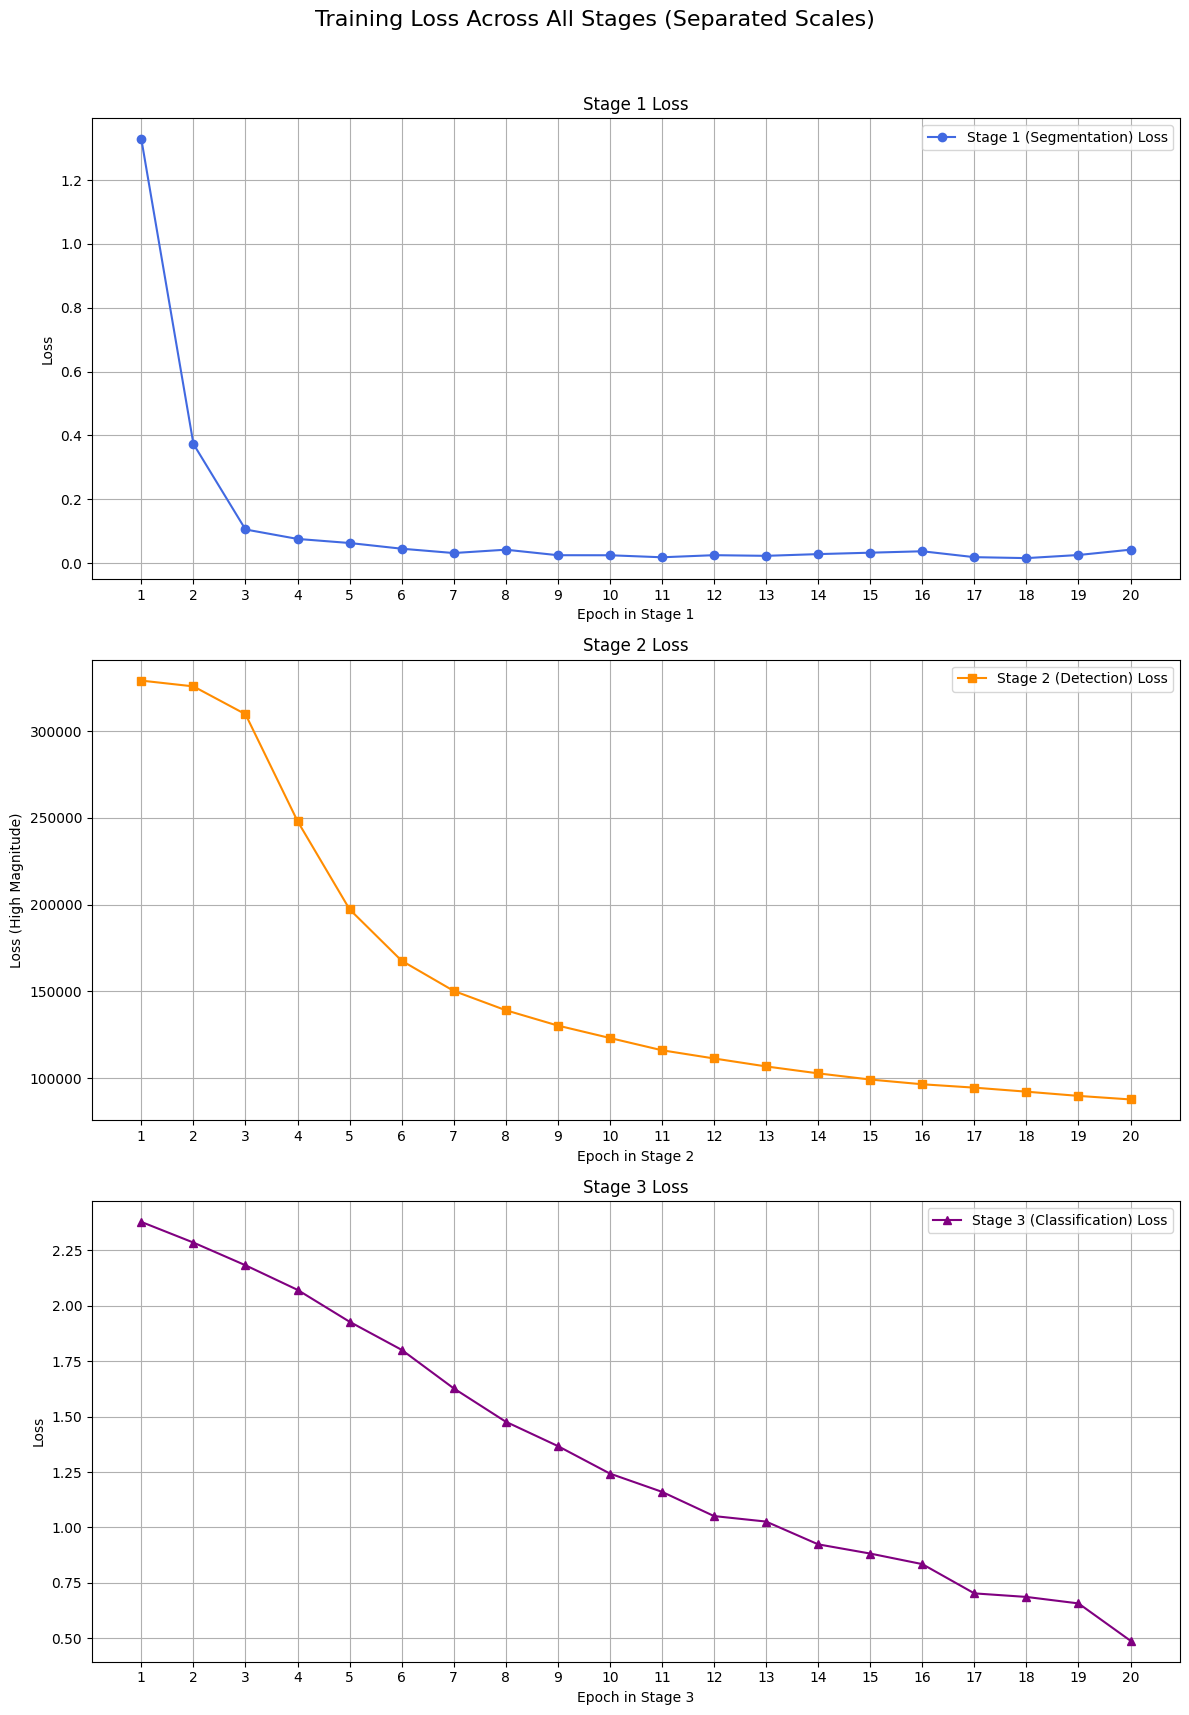

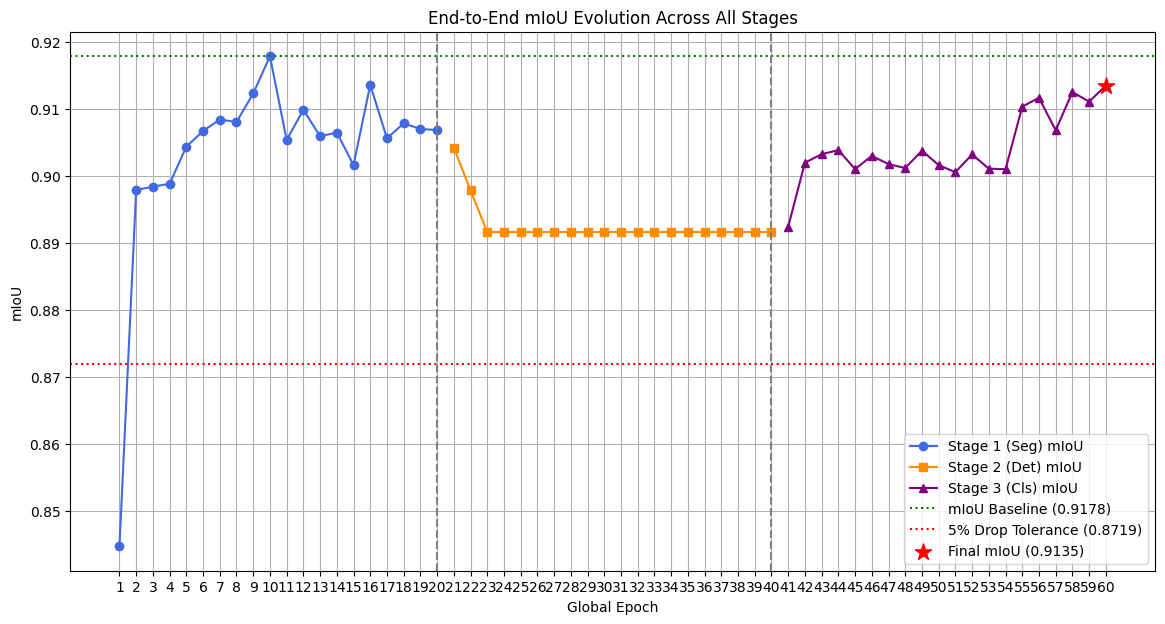

In [18]:
# ===============================================
# üìä Ë®ìÁ∑¥ÈÅéÁ®ãË¶ñË¶∫ÂåñÂàÜÊûê (ÂÑ™ÂåñÁâà)
# ===============================================
import matplotlib.pyplot as plt

# --- 1. Loss ËÆäÂåñÂàÜÊûêÂúñ (ÊãÜÂàÜÁÇ∫‰∏âÂÄãÂ≠êÂúñ) ---
# Âª∫Á´ã‰∏ÄÂÄãÂåÖÂê´ 3 ÂÄãÂ≠êÂúñÁöÑ FigureÔºåÊéíÂàóÁÇ∫ 3 Ë°å 1 Âàó
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Training Loss Across All Stages (Separated Scales)', fontsize=16)

# Â≠êÂúñ 1: Stage 1 (Segmentation)
axes[0].plot(range(1, stage1_len + 1), loss1_hist, 'o-', color='royalblue', label='Stage 1 (Segmentation) Loss')
axes[0].set_title('Stage 1 Loss')
axes[0].set_xlabel('Epoch in Stage 1')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(ticks=range(1, stage1_len + 1))

# Â≠êÂúñ 2: Stage 2 (Detection)
axes[1].plot(range(1, stage2_len + 1), loss2_hist, 's-', color='darkorange', label='Stage 2 (Detection) Loss')
axes[1].set_title('Stage 2 Loss')
axes[1].set_xlabel('Epoch in Stage 2')
axes[1].set_ylabel('Loss (High Magnitude)')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(ticks=range(1, stage2_len + 1))


# Â≠êÂúñ 3: Stage 3 (Classification)
axes[2].plot(range(1, stage3_len + 1), loss3_hist, '^-', color='purple', label='Stage 3 (Classification) Loss')
axes[2].set_title('Stage 3 Loss')
axes[2].set_xlabel('Epoch in Stage 3')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(ticks=range(1, stage3_len + 1))

# Ëá™ÂãïË™øÊï¥Â≠êÂúñÈñìË∑ùÔºåÈÅøÂÖçÊ®ôÁ±§ÈáçÁñä
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


# --- 2. mIoU ÂÆåÊï¥ÊºîÂåñË∂®Âã¢Âúñ (‰øùÊåÅ‰∏çËÆä) ---
plt.figure(figsize=(14, 7))

# Áπ™Ë£Ω‰∏âÂÄãÈöéÊÆµÁöÑ mIoU ÊºîÂåñÊõ≤Á∑ö
plt.plot(range(1, stage1_len + 1), miou1_hist, 'o-', color='royalblue', label='Stage 1 (Seg) mIoU')
plt.plot(range(stage1_len + 1, stage1_len + stage2_len + 1), miou2_hist, 's-', color='darkorange', label='Stage 2 (Det) mIoU')
plt.plot(range(stage1_len + stage2_len + 1, stage1_len + stage2_len + stage3_len + 1), miou3_hist, '^-', color='purple', label='Stage 3 (Cls) mIoU')

# Ê®ôÁ§∫Âü∫Ê∫ñÁ∑öÂíå 5% ‰∏ãÈôçÁöÑÂÆπÂøçÁ∑ö
mIoU_final = miou3_hist[-1] if miou3_hist else (miou2_hist[-1] if miou2_hist else miou1_hist[-1])
plt.axhline(y=mIoU_base, color='green', linestyle=':', label=f'mIoU Baseline ({mIoU_base:.4f})')
plt.axhline(y=mIoU_base * 0.95, color='red', linestyle=':', label=f'5% Drop Tolerance ({mIoU_base*0.95:.4f})')

# Áπ™Ë£ΩÈöéÊÆµÂàÜÈöîÁ∑ö
plt.axvline(x=stage1_len, color='grey', linestyle='--')
plt.axvline(x=stage1_len + stage2_len, color='grey', linestyle='--')

# Ê®ôÁ§∫ÊúÄÁµÇÁµêÊûú
plt.scatter(len(all_mious), mIoU_final, s=150, c='red', marker='*', zorder=5, label=f'Final mIoU ({mIoU_final:.4f})')

plt.title('End-to-End mIoU Evolution Across All Stages')
plt.xlabel('Global Epoch')
plt.ylabel('mIoU')
plt.xticks(ticks=range(1, len(all_mious) + 1))
plt.legend()
plt.grid(True)
plt.show()